# Exploring the UTx000 Extension Beacon Data
(See the [GH repo](https://github.com/intelligent-environments-lab/utx000))

In [504]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Estimating Ventilation Rates
Using CO$_2$, we can estimate the ventilation rates in the space using various methodologies. 

This notebook uses the `ventilation.py` source code included in this project. This script includes a superclass `calculate` with two child subclasses `steady_state` and `decay` which estimate the vnetilation rate with those two methods, repsectively. 

## Package Import

In [505]:
import os
import sys
sys.path.append('../')

from src.visualization import visualize
from src.analysis import ventilation

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import math
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

---

# Notes on Data Used
The necesary data are imported when insantiating a `calculate` object. 

## Beacon Data
We are primarily concerned with the beacon data when participants are asleep since that is the only time we can be sure participants are home in their bedrooms. However, we also need all the processed beacon since the methods in the `decay` class utilize measurements made after the occupant has awakened. Therefore, we have three datasets from the beacon measurements:

1. **All**: All the IAQ measurements made by the beacons indexed by the timestamp.
2. **Nightly Measurements**: IAQ Measurements made by the beacons during Fitbit identified sleep events which have also been cross-referenced with GPS data to confirm participants are in the same location as the beacon during sleep events.
3. **"Morning" Measurements**: IAQ measurements made by the beacons a _certain_ period after participants have awakened. These periods are not necessarily confined to morning hours since some participants had non-traditional sleep schedules and the period can be toggled to whatever hour.

## Participant Information
We need the participant beacon, beiwe, and fitbit IDs so we can cross-reference the various pieces of information. This dataset contains other information including the sex of the individual and the estimated volume of their bedrooms (depends on the dwelling type). 

## Fitbit Data
Beacon data have already been parsed out according to Fitbit-detected sleep events. The only time we need Fitbit data is for the weight that participants included when _originally_ signing up for an account since the estimated respiration rate depends on the boddy mass of the participant. 

---

# Ventilation based on constant CO2 concentration
We can estimate the ventilation rate of the participants' bedrooms based on a constant CO2 concentration:

$$
\lambda = \frac{E}{V \left(C - pC_0\right)}
$$

In our case we have to make quite a few assumptions:
- [$E$](#e): Emission rate of CO2 can be estimated for humans to be approximately $30 g/hr$. We can further refine this value by considering the height, weight, sex, and activity level of the participant - all information that we have access to. 
- [$V$](#V): Arguably the most difficult value to track down and the one that could affect the answer the most. We can assume a volume of each of the participants bedrooms, but there is the possiblility of refining this value by cross-referencing the participants' addresses with any known apartment complexes. From there, we can estimate the floor plan based on the number of roommates.
- $p$: Penetration factor of CO2 from outside into the indoor space - we can safely assume this to be 1.
- $C_0$: Outdoor concentration of CO2 - another safe assumption of 400 ppm. 

The subsequent sections dive a bit deeper into each of the parameters.

<a id="e"></a>

<a id="emission_rate_discussion"></a>

## Emission Rate
Based on an article that Sangeetha sent me, we can determine the emission rate of CO2 from the following equation:

$$
V_{CO_2} = (BMR)(M)(T/P)(0.000179)
$$

where:
- $V_{CO_2}$ is the volumetric emission rate of CO2 in L/s
- $BMR$ is the body mass ratio determined from Persily and De Jonge 2016
- $M$: Activity level in METs
- $T$ is the temperature in Kelvin
- $P$ is the pressure in kPa

### Body Mass Ratio
The body mass ratio is given by one of the two equations since our participants are in the age range of 18-30

$$
BMR_{male} = 0.063m + 2.896\\
BMR_{female} = 0.062m + 2.036
$$

where $m$ is the body mass in kilograms. We have the pariticpants body weights assuming they logged them into Fitbit. We can grab these data and put it alongside the participants beacon, beiwe, and fitbit IDs. We take the body weight for each participant, average it over the total amount of time logged (just in case they changed it which I doubt anyone did) and store that value.

Then we calculate the BMR based on the mass and sex of the participants

### Activity Level in METs
The Persily and De Jong 2016 article gives values for activity level in METs dependingon the activity. We can assume that our participants are asleep since we are only using data when Fitbit detects sleeping individuals. The MET value for a sleeping individual, from the article, is **0.95**.

### Temperature and Pressure
The **temperature will vary depending on the night** that we choose to analyze and therefore will alter the emission rate of CO2. Thus we have to account for the temperature.

The pressure will more or less remain constant since we are at the same altitude for the most part in Austin. The National Weather Service has a [station at the airport](https://w1.weather.gov/data/obhistory/KAUS.html) in Austin that reports the atmopsheric pressure is around **102.5 kPa**.

<a id="V"></a>

## Volume
We can always assume a value for the volume of the space, or we can go a bit more in-depth by looking at the addresses of the participants.

Doing this presents their own set of problems since we now have to trust the answers of the participants and the addresses could be different than the addresess we sent the beacons to. Rather, we can simply use average numbers:
- **Stand-Alone Home**: We can use the US average of 11x12 feet with 9 foot ceilings - **1188 feet**
- **Apartment**: Another average value would be 10x12 with 9 foot ceilings - **1080 feet**

<div class="alert-block alert alert-success">
The volumes have been added to the info.csv file for each participant based on the address used to ship the beacons to.
<div>

### Estimating volume based on CO2 growth

<div class="alert-block alert alert-danger">
The results from this analysis were never used since the volumes they returned were erroneous.
<div>

While not a good estimate, we can use periods of uniterrupted CO2 concentration increases to estimate what the volume of the space might be. Under these conditions, we might assume the the contribution from outdoors is negligible and we simply have accumulation:

$$
V \frac{dC}{dt} = E
$$

We can rearrange the original equation to solve for the volume.

In [506]:
volume_estimate = ventilation.calculate(data_dir="../data")

In [507]:
v_estimates = volume_estimate.estimate_volume_from_co2(volume_estimate.beacon_nightly,volume_estimate.info)
v_estimates

beacon  starting_co2   co2_delta   ending_co2       R^2  \
beiwe                                                               
745vq78e     5.0   1456.543595  124.669769  1581.213365  0.993354   
9jtzsuu8    15.0   1190.336830  126.249838  1316.586668  0.995697   
9xmhtq74    17.0    676.894016   34.167035   711.061052  0.998229   
awa8uces    26.0   1285.889838   39.119771  1325.009609  0.993907   
e73a1pd5    16.0   3555.177007  303.247406  3858.424413  0.994127   
i31pt4b4    11.0   2179.054785   90.084338  2269.139123  0.994632   
idbkjh8u    30.0   1118.820121   33.434276  1152.254398  0.990073   
kyj367pi     1.0    714.155082   45.950021   760.105103  0.994741   
lkkjddam    21.0   1083.115539  162.259918  1245.375456  0.994288   
nvtfpaor    46.0   1281.463238   60.081856  1341.545093  0.994106   
olaxadz5    38.0   1179.883488   65.656183  1245.539671  0.993245   
qh34m4r9    19.0    917.609797   42.539338   960.149135  0.995955   
tlmlq19s    36.0    898.084750   97.180746   995.265496  0.992962   
tmexej5v    29.0    931.467467   51.159211   982.626677  0.994797   
xdbdrk6e    24.0   1293.607008   47.226578  1340.833586  0.996028   
xlw5ntd5    10.0   1237.699926  323.948016  1561.647942  0.994152   
zdpffrox     7.0   1749.287920   75.502429  1824.790350  0.996208   

           volume_est  volume_gen  
beiwe                              
745vq78e  4370.344945      1188.0  
9jtzsuu8  4068.524845      1188.0  
9xmhtq74  6370.614565      1080.0  
awa8uces  4084.202987      1188.0  
e73a1pd5  1517.619357      1080.0  
i31pt4b4  5325.167339      1080.0  
idbkjh8u  8869.014008      1080.0  
kyj367pi  8133.603136      1080.0  
lkkjddam  5265.675741      1188.0  
nvtfpaor  4614.148239      1188.0  
olaxadz5  5991.090212      1188.0  
qh34m4r9  7259.856492      1188.0  
tlmlq19s  7958.826044      1188.0  
tmexej5v  5516.510132      1188.0  
xdbdrk6e  7671.728358      1188.0  
xlw5ntd5  4313.262839      1188.0  
zdpffrox  6847.944476      1365.0

## Background CO2
We have two options for the background CO$_2$ concentration, both of which introduce their own set of problems.

* **Constant Value**: we can assume the background CO2 concentration is ~450 ppm for each participant which is likely true for the outdoor conditions, but might not be a fair assumption since CO$_2$ concentrations might be, on average, higher in the household.
* **Participant-Based Value**: we can use participant-specific data to estimate a background concentration by using a lower-percentile concentration or the minimum. This process results in vastly different background concentrations but is likely more realistic. 

## Constant CO2
Now we need to find periods during the evening when the CO2 concentration is constant. We can do this by looking at the mean difference in CO2 concentration during a certain window. If the change is less than a certain threshold, we can then assume the concentration is stable.

We can also cross-reference with the temperature to make sure that the AC isn't just cycling on and off quickly keeping the CO2 within a tight window. 

## Air Exchange Rate
Now we have all the information we need for the equation, we can determine the air exchange rate in each of the participants' homes.

We do need to find some extra information to convert our units:
- **Density of CO2 ($\rho_{CO_2}$)**: The density of CO2 can be found [here](www.engineeringtoolbox.com/carbon-dioxide-density-specific-weight-temperature-pressure-d_2018.html). We want to look for nearly atmospheric pressure and room temperature.
- **Conversions**: Like cubic feet to cubic meters, ppm to g/m$^3$, and the like.

## Calculating emission rates and ventilation rates

In [508]:
ss_calc = ventilation.steady_state(data_dir="../data")

In [509]:
estimates_ss = ss_calc.ventilation_ss(ss_calc.beacon_nightly,ss_calc.info,constant_c0=False,c0_percentile=0)

In [510]:
estimates_ss["date"] = ss_calc.get_ventilation_sleep_date(estimates_ss,decay=False)
estimates_ss.describe()

beacon     co2_mean   co2_delta      t_mean     t_delta  \
count  336.000000   336.000000  336.000000  336.000000  336.000000   
mean    22.264881  1051.140182   -0.124675   25.217213   -0.013144   
std     10.599553   368.565235    1.462294    2.962701    0.015366   
min      1.000000   600.509634   -5.581866   16.007787   -0.110042   
25%     17.000000   792.599858   -0.565419   23.618296   -0.018157   
50%     21.000000   979.397773    0.038094   25.441243   -0.008261   
75%     29.000000  1258.699755    0.553356   27.010085   -0.002061   
max     46.000000  4356.688852    6.255600   32.702303    0.000000   

                e           c0            v         ach  
count  336.000000   336.000000   336.000000  336.000000  
mean     0.003079   591.395086  1168.812500    1.048068  
std      0.000490   156.730984    60.553644    0.668791  
min      0.002467   236.604189  1080.000000    0.169464  
25%      0.002683   525.802586  1188.000000    0.531449  
50%      0.002829   569.124672  1188.000000    0.813466  
75%      0.003728   626.724852  1188.000000    1.428402  
max      0.004067  2347.186916  1365.000000    2.939389

---

<a id="decay"></a>

# Ventilation based on CO2 decay
We can estimate the ventilation rate of the participants' bedrooms based on a decay in the CO2 concentration:

$$
C_t = C_{t=0}e^{-\lambda t} + \left(pC_0 + \frac{E}{\lambda V}\right)\left(1 - e^{-\lambda t}\right)
$$

The benefit of this approach is that the exchange rate we get might be agnostic to the accuracy of the sensor assuming the sensor is precise (just off from the true value by a constant difference).

Many of the variables from the previous analysis show up here again which is nice since we already found those. 
- $C_t$: CO2 concentation at some time, $t$
- $C_{t=0}$: CO2 concentration at the beginning of the analysis period
- $E$: Emission rate of CO2 estimated from the Persily and Jonge (2016) paper which looks at the activity, sex, and BMR of the participant. 
- $V$: We opted for a more generic value rather than diving too deep.
- $\lambda$: air exchange rate
- $p$: Penetration factor of CO2 from outside into the indoor space - we can safely assume this to be 1.
- $C_0$: Outdoor concentration of CO2 - another safe assumption of 400 ppm. 

There are two challenges with this approach:
1. What data do we need and from what time?
1. How do we identify periods of CO2 decay?
2. The solution involves an iterative approach since we cannot easily solve for the air exchange rate, $\lambda$
3. What error metrics should we use to ensure we have the optimal solution?
4. What value(s) should be used for the background concentration?

## Occupant still in the space (Eq. 1)
If we do not assume that the participant left the space, we can directly apply the above equation. We had to go through a similar process we did when estimating the air exchange rate based on a constant CO2 concentration i.e. we need the emission rate and the volume of the space. 

## Occupant leaves (Eq. 2)
If the participant leaves the bedroom, we don't have any emission sources. Therefore, our equation simplifies to:

$$
C_t = C_{t=0}e^{-\lambda t} + pC_0\left(1 - e^{-\lambda t}\right)
$$

## Occupant leaves and no outdoor penetration (Eq. 3)
By not considering any outdoor penetration, we can further simplify our equation:

$$
C_t = C_{t=0}e^{-\lambda t}
$$

In [511]:
decay_calc = ventilation.decay(data_dir="../data")

## Background Concentration
The analysis shown below (see [Diagnosing Decay Results](#diagnosing_decay)) highlights that the assumption of a 450 ppm background concentration results in _low_ `ach` measurements. This assumption is safer for a leakier, typically unoccupied space -- such as a classroom -- but does not hold for this analysis. Rather than assume some concentration, we should use the participant-based approach.

<div class="alert-block alert alert-warning">

As of right now, the methods that incorporate a background concentration are using the **1st percentile** CO$_2$ concentration per each participant. 
<div>

## Beacon Data after Waking
We need to grab a different set of beacon data to do this assessment. Instead of looking at CO2 data during the evening, we actually need the CO2 data for a few hours right _after_ the participants woke up. We should be able to easily do this by looking at the stop times from the filtered beacon data and parsing out timestamps for the few hours after this from the processed beacon data.

In [512]:
morning_beacon_co2 = decay_calc.get_morning_beacon_data(decay_calc.beacon_nightly,decay_calc.beacon_all,num_hours=3)
decay_calc.set_beacon_morning(morning_beacon_co2)
decay_calc.beacon_morning.head()

beiwe  beacon          co2  temperature_c         rh  \
timestamp                                                                      
2020-07-18 12:42:00  nvtfpaor      46  1412.732789      26.792008  35.096667   
2020-07-18 12:44:00  nvtfpaor      46  1410.979668      26.792008  35.130000   
2020-07-18 12:46:00  nvtfpaor      46  1409.486384      26.792008  35.156667   
2020-07-18 12:48:00  nvtfpaor      46  1407.771363      26.792008  35.156667   
2020-07-18 12:50:00  nvtfpaor      46  1405.573392      26.792008  35.156667   

                             start_time  
timestamp                                
2020-07-18 12:42:00 2020-07-18 12:40:30  
2020-07-18 12:44:00 2020-07-18 12:40:30  
2020-07-18 12:46:00 2020-07-18 12:40:30  
2020-07-18 12:48:00 2020-07-18 12:40:30  
2020-07-18 12:50:00 2020-07-18 12:40:30

## Identifying periods of decay
We just need to call the function ```get_co2_periods()``` but set the ```change``` parameter to```'decreasing'```. A consideration of the temperature during the evening has been incorporated into this function to account for the AC operation which originally wasn't included. 

## Iteratively solving for ventilation rate
Now that we can get the periods of decreasing CO2 concentration, we can use the dynamic solution and continuously vary the air exchange rate until we get the lowest error between the measured and estimated concentrations at $t > 0$.

We opt for a "brute-force" method rather than something more sophisticated since the run-times are low since we have a limited range of `ach` to consider in addition to a limited accuracy threshold.

## Calculating
* [Eq 3: No occupant and no penetration](#calc_1)
* [Eq 2: No occupant](#calc_2)
* [Eq 1: Full](#calc_3)

<a id="calc_3"></a>

### Occupant leaves and no outdoor CO2 penetration (Eq 3)
The most simple case we have: basic decay equation.

In [513]:
decay_3 = decay_calc.ventilation_decay_no_occupant_no_penetration(decay_calc.beacon_morning, decay_calc.info)

In [530]:
decay_3["date"] = decay_calc.get_ventilation_sleep_date(decay_3,decay=True)
decay_3.describe()

beacon  ending_co2_meas  ending_co2_calculated       rmse        ach
count  80.000000        80.000000              80.000000  80.000000  80.000000
mean   22.912500         1.870487               1.856001   0.016271   0.109825
std     9.465719         0.888099               0.880753   0.018047   0.071533
min     1.000000         1.114160               1.018737   0.000917   0.025000
25%    18.500000         1.455840               1.418310   0.005908   0.061000
50%    21.000000         1.688759               1.646820   0.010193   0.096000
75%    29.000000         2.018370               2.020529   0.018841   0.133250
max    46.000000         7.267061               7.206704   0.103549   0.375000

<a id="calc_2"></a>

### Occupant leaves (Eq 2)
Now we add in some penetration from outdoors

In [515]:
decay_2 = decay_calc.ventilation_decay_no_occupant(decay_calc.beacon_morning, decay_calc.info, constant_c0=False, c0_percentile=0)

In [531]:
decay_2["date"] = decay_calc.get_ventilation_sleep_date(decay_2,decay=True)
decay_2.describe()

beacon  ending_co2_meas  ending_co2_calculated       rmse        ach
count  80.000000        80.000000              80.000000  80.000000  80.000000
mean   22.912500         1.870487               1.865766   0.015001   0.285087
std     9.465719         0.888099               0.883860   0.016985   0.202183
min     1.000000         1.114160               1.086571   0.000912   0.042000
25%    18.500000         1.455840               1.433783   0.006210   0.142750
50%    21.000000         1.688759               1.663312   0.010553   0.236000
75%    29.000000         2.018370               2.023612   0.016304   0.386000
max    46.000000         7.267061               7.222245   0.120901   1.067000

<a id="calc_1"></a>

### Occupant stays (Eq 1)
Lastly, we add in an emission source (the participant stays in their bedroom).

<div class="alert-block alert alert-danger">
    
Estimates from this method are not reliable and violate the assumption that the occupant has left their bedroom.'
    
<div>

In [517]:
decay_1 = decay_calc.ventilation_decay_full(decay_calc.beacon_morning, decay_calc.info)

In [532]:
decay_1["date"] = decay_calc.get_ventilation_sleep_date(decay_1,decay=True)
decay_1.describe()

beacon  ending_co2_meas  ending_co2_calculated       rmse        ach
count  80.000000        80.000000              80.000000  80.000000  80.000000
mean   22.912500         1.870487               1.423461   0.288045   2.537438
std     9.465719         0.888099               0.937737   0.160055   4.290932
min     1.000000         1.114160               0.564513   0.010282   0.001000
25%    18.500000         1.455840               1.037718   0.203996   0.001000
50%    21.000000         1.688759               1.201891   0.272425   0.001000
75%    29.000000         2.018370               1.554470   0.375208   5.866750
max    46.000000         7.267061               7.203050   0.735508  10.000000

## Saving

### Combining Estimates
Putting everything in one dataframe

In [533]:
estimates = {"ss":estimates_ss, "decay_1":decay_1, "decay_2":decay_2, "decay_3":decay_3}
estimates_df = pd.DataFrame()
for key in estimates.keys():
    # adding columns to group on
    estimates[key]["method"] = key
    estimates_df = estimates_df.append(estimates[key])
    
estimates_summarized = estimates_df.groupby(["beiwe","date","method"]).mean().reset_index()

In [534]:
estimates_summarized.head()

beiwe        date method  beacon     co2_mean  co2_delta     t_mean  \
0  745vq78e  2020-06-11     ss     5.0  1630.894481  -1.722181  26.893988   
1  745vq78e  2020-06-12     ss     5.0  1460.549967   1.123542  27.377432   
2  745vq78e  2020-06-14     ss     5.0  1397.203223  -0.824000  26.609234   
3  745vq78e  2020-06-15     ss     5.0  1658.106142  -1.198516  26.826617   
4  745vq78e  2020-06-17     ss     5.0  1299.296623  -0.502997  27.855932   

    t_delta         e          c0       v       ach  ending_co2_meas  \
0 -0.000460  0.002664  836.009227  1188.0  0.359469              NaN   
1 -0.022445  0.002668  836.009227  1188.0  0.458252              NaN   
2 -0.010191  0.002661  836.009227  1188.0  0.509207              NaN   
3 -0.011492  0.002663  836.009227  1188.0  0.361254              NaN   
4 -0.012368  0.002673  836.009227  1188.0  0.618737              NaN   

   ending_co2_calculated  rmse  
0                    NaN   NaN  
1                    NaN   NaN  
2                    NaN   NaN  
3                    NaN   NaN  
4                    NaN   NaN

In [535]:
estimates_summarized["method"].unique()

array(['ss', 'decay_1', 'decay_2', 'decay_3'], dtype=object)

In [536]:
estimates_summarized.to_csv("../data/processed/beacon-ventilation.csv",index=False)

### Steady-State

In [522]:
estimates_ss.to_csv("../data/processed/beacon-ventilation_estimates-ss-ux_s20.csv",index=False)

### Decay

In [523]:
estimates_decay = estimates_df[estimates_df["method"] != "ss"]
estimates_decay.to_csv("../data/processed/beacon-ventilation_estimates-decay-ux_s20.csv",index=False)

---

# Analyzing Results
Now that we have calculated the ventilation rates through four methods, we can compare the results. 

## All Methods
We start by looking at the results from all four methods.

<div class="alert-block alert alert-danger">
    
There is no reason to include the estimates from `decay_3` since we are assuming the participant left and the values are at the upper limit meaning that the optimization step failed.
    
<div>

In [443]:
estimates_summarized_no1 = estimates_summarized[~estimates_summarized["method"].isin(["decay_1","decay_3"])]

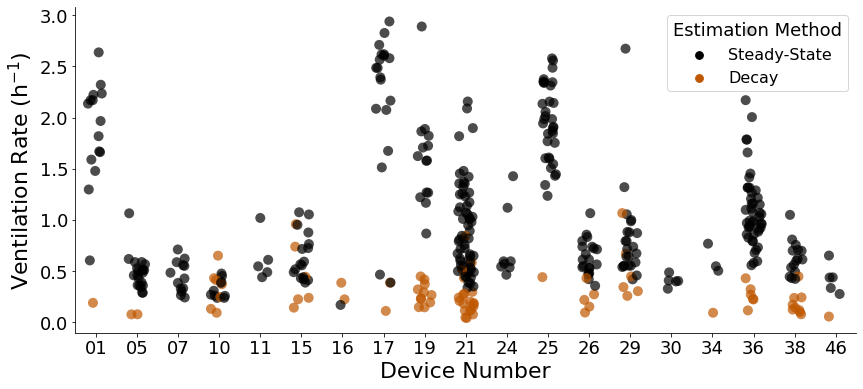

In [447]:
ventilation.plot_strip(estimates_summarized_no1[estimates_summarized_no1["ach"] < 4],save=True)

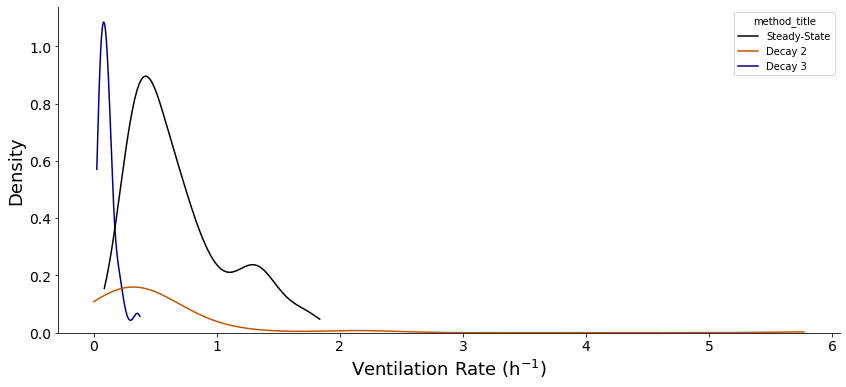

In [56]:
ventilation.plot_distribution(estimates_summarized_no1)

<div class="alert-block alert alert-info">
    
**Steady-State**: These results make sense since most are within 0.5 - 2.5.
    
**Decay**: The decay estimates are nearly all lower than the steady-state estimates which might be influenced by the assumptions we use.
<div>

## Steady-State

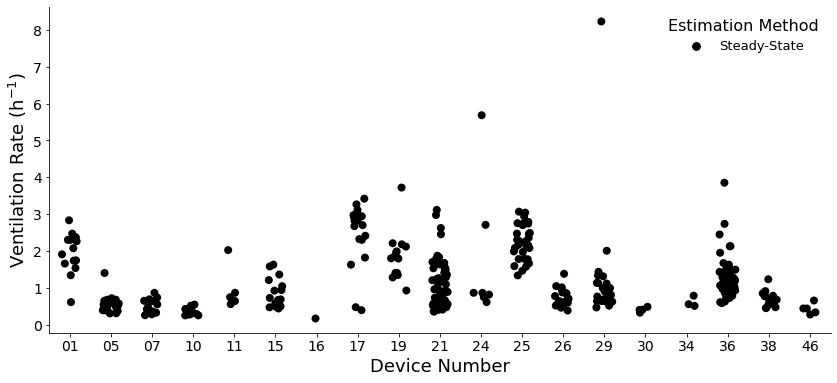

In [197]:
ventilation.plot_strip(estimates_summarized[estimates_summarized["method"].isin(["ss"])])

<div class="alert-block alert alert-info">
    
The steady-state results look good and rely on fewer assumptions than the decay method(s) which helps reinforce their use in subsequent analysis.
<div>

## Decay - No Occupant (Eq 2)
The most accurate estimation method yet the values are still much lower than those estimated by the steady-state method so we want to look a bit closer.

In [58]:
# beiwe-beacon mapping
estimates_summarized[["beiwe","beacon","ach"]].groupby("beiwe").mean().sort_values("beacon")

beacon       ach
beiwe                     
kyj367pi     1.0  1.562808
745vq78e     5.0  0.225964
zdpffrox     7.0  0.322929
xlw5ntd5    10.0  0.240694
i31pt4b4    11.0  0.294970
9jtzsuu8    15.0  1.569300
e73a1pd5    16.0  0.197152
9xmhtq74    17.0  1.329413
qh34m4r9    19.0  1.219739
lkkjddam    21.0  0.859567
xdbdrk6e    24.0  0.310039
vr9j5rry    25.0  1.654619
awa8uces    26.0  0.585048
tmexej5v    29.0  0.498139
idbkjh8u    30.0  0.494455
rnse61g4    34.0  0.283320
tlmlq19s    36.0  1.005137
olaxadz5    38.0  0.230683
nvtfpaor    46.0  0.242783

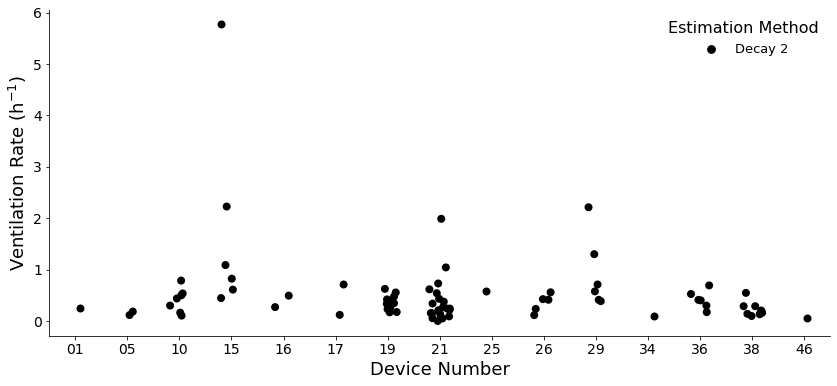

In [59]:
ventilation.plot_strip(estimates_summarized[estimates_summarized["method"].isin(["decay_2"])])

<div class="alert-block alert alert-info">
    
These results are the most promising from the decay methods, but are still low. While these values are not outside the realm of possibility, they don't match up well with the steady-state results which warrants a closer look.
<div>

<a id="diagnosing_decay"></a>

### Diagnosing Results
Many of the results from the decay method look _too_ linear.

We start by looking at the diagnostic figures which should provide some example data that we can pull and use. From there, we can do some tinkering with the inputs and assumptions to see how we can match the values/curves.

In [60]:
def compare_decays(period_df,ells=[0.1,0.5,1],p=1.0,c0=400.0,measurement_resolution=120,**kwargs):
    """
    Compares measured values to decay estimates
    
    Parameters
    ----------
    period_df : DataFrame
        co2 data from one period
    ells : list, default [0.1,0.5,1]
        test air exchange rates
    p : float, default 1.0
        penetration factor
    c0 : float, default 400.0
        background co2 concentration in ppm
    measurement_resolution : int, default 120
        interval between measurements in seconds
        
    Returns
    -------
    <void>
    """
    # plotting original
    _, ax = plt.subplots(figsize=(12,4))
    ax.plot(period_df.index,period_df["co2"],color="black",lw=3,label="Measured")
    # estimating concentrations and plotting
    ct0 = period_df["co2"][0]
    for ell in ells:
        c = []
        for i in range(len(period_df)):
            t = i*measurement_resolution/3600
            c.append(ct0*math.exp(-ell*t) + (p*c0)*(1 - math.exp(-ell*t)))
        
        ax.plot(period_df.index,c,label=f"ACH = {ell} "+"h$^{-1}$")
        
    if "optimal" in kwargs.keys():
        c_optimal = []
        ell = kwargs["optimal"]
        for i in range(len(period_df)):
            t = i*measurement_resolution/3600
            c_optimal.append(ct0*math.exp(-ell*t) + (p*c0)*(1 - math.exp(-ell*t)))
        
        ax.plot(period_df.index,c_optimal,color="seagreen",lw=2,linestyle="dotted",label=f"ACH = {ell} "+"h$^{-1}$ (optimal)")
            
    ax.legend(frameon=False)
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    plt.show()
    plt.close()

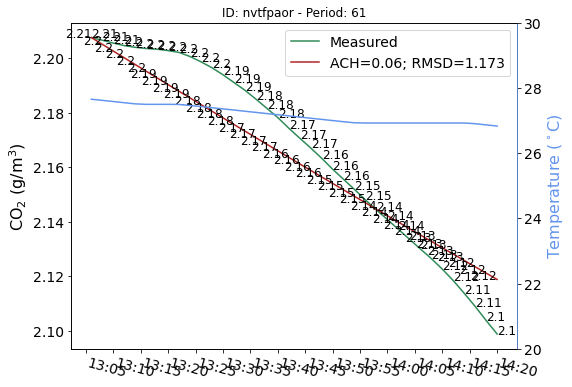

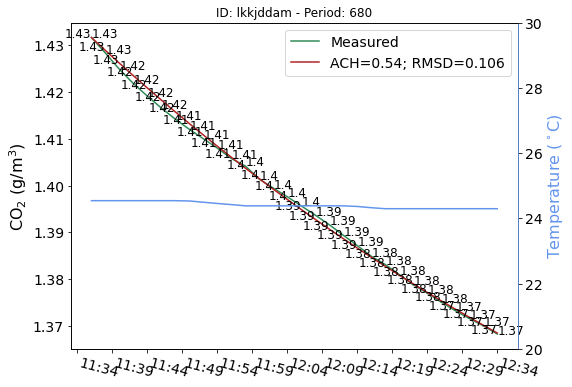

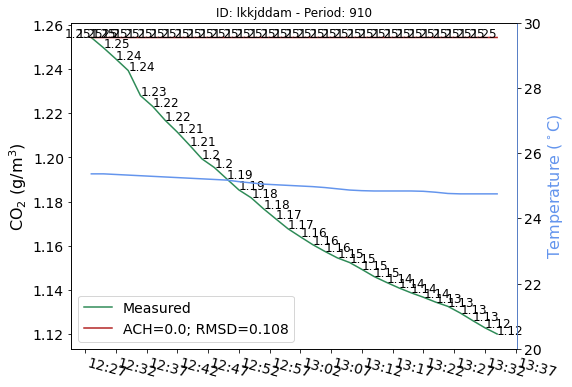

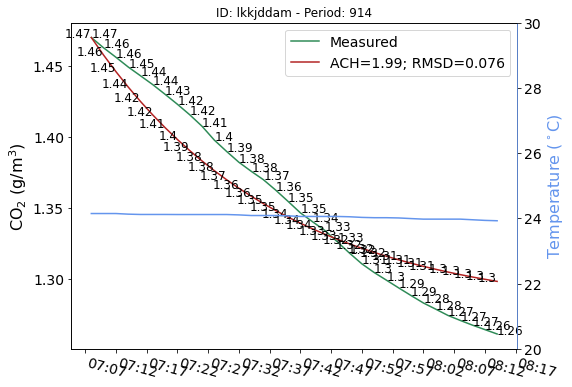

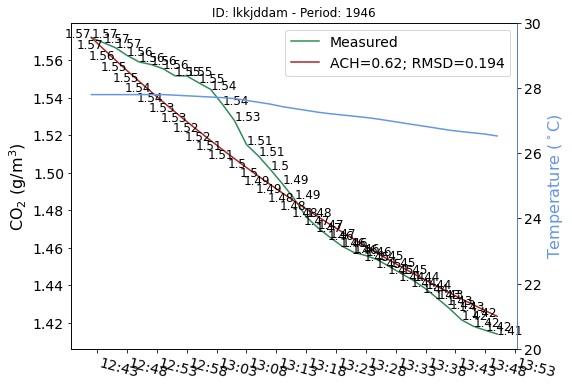

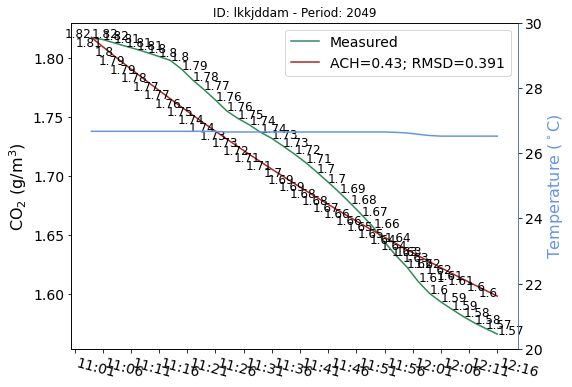

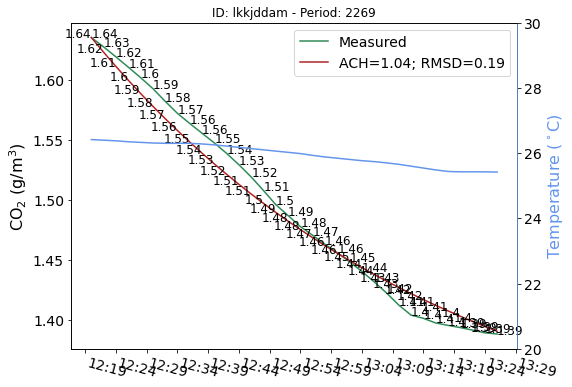

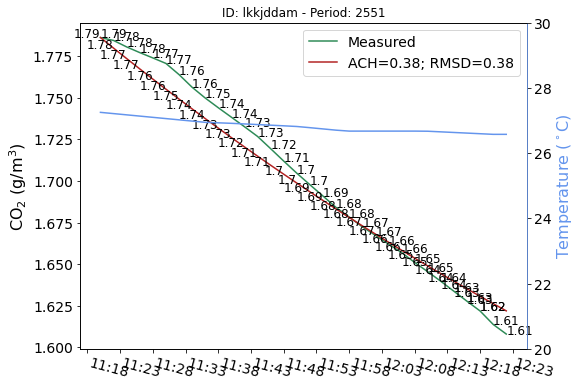

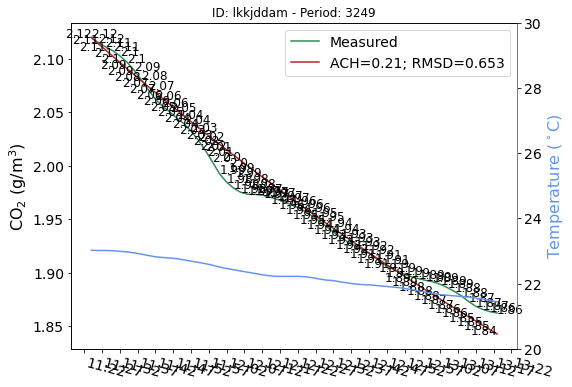

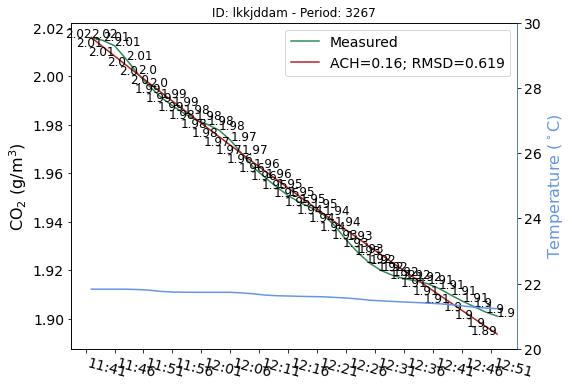

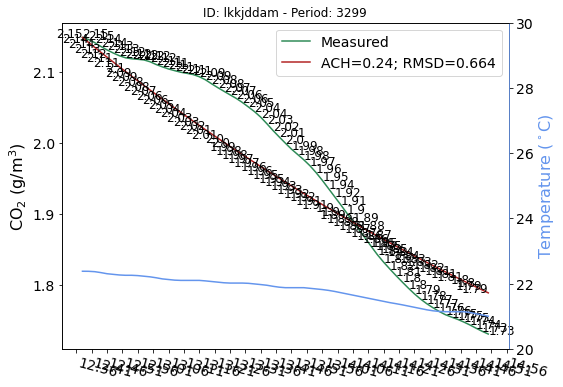

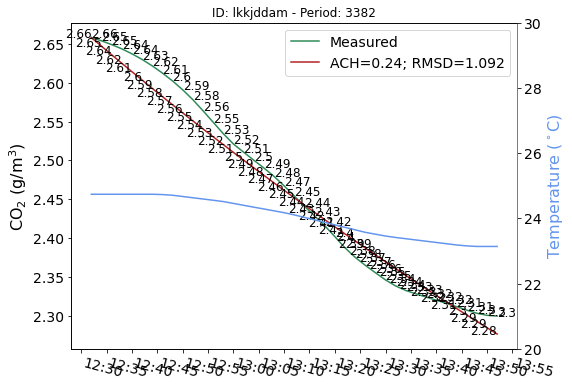

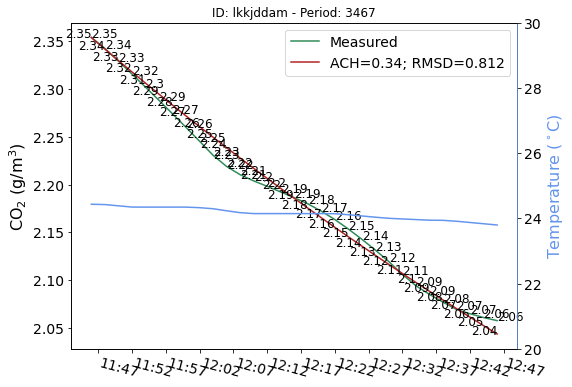

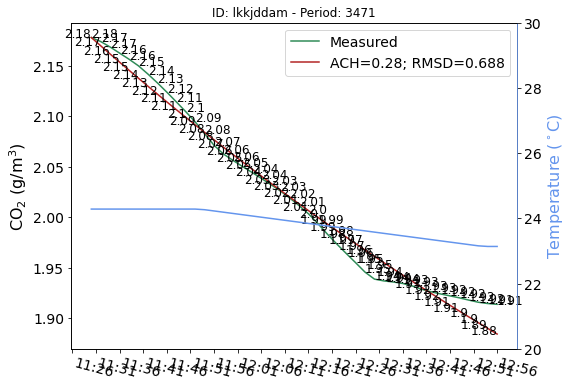

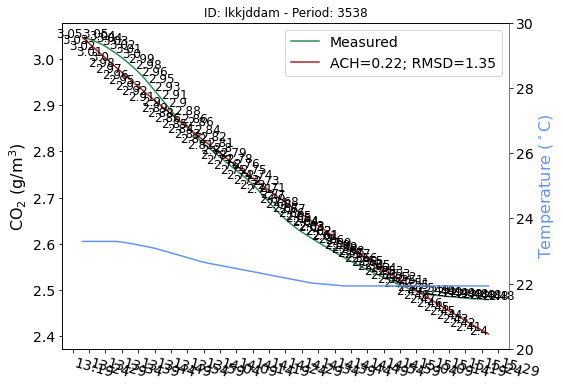

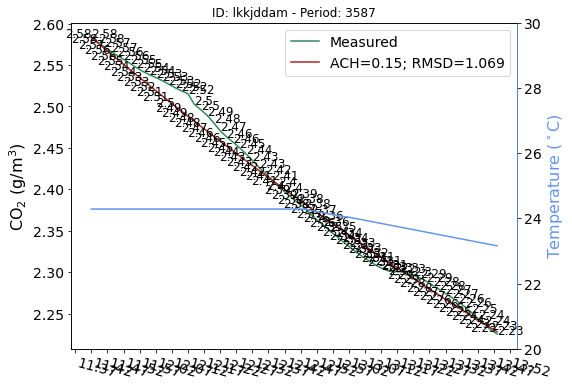

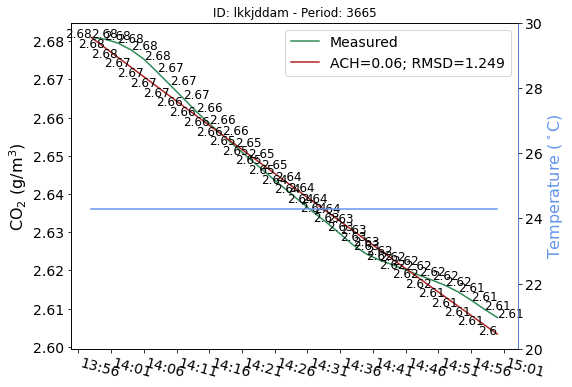

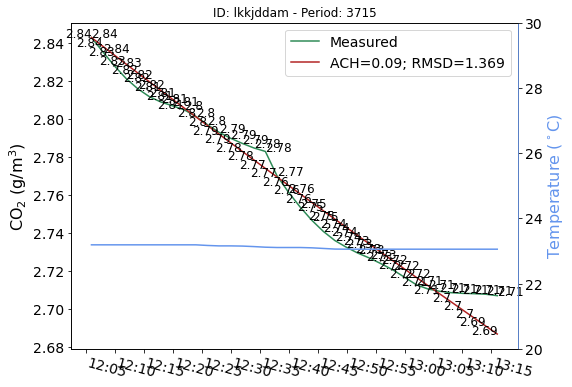

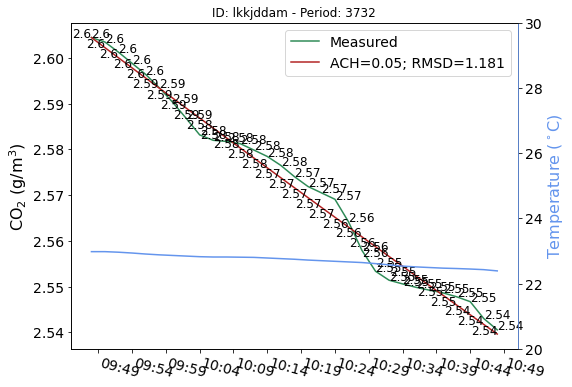

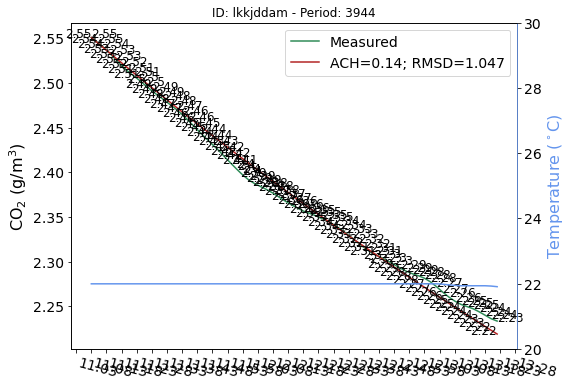

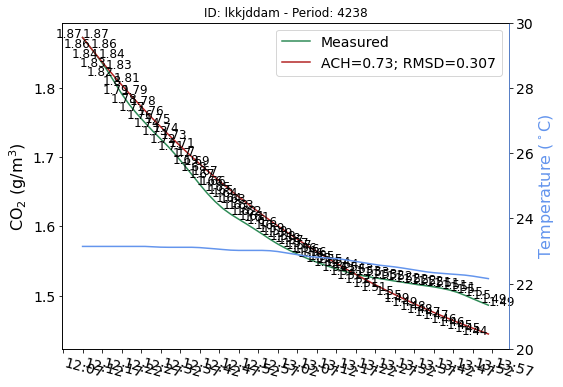

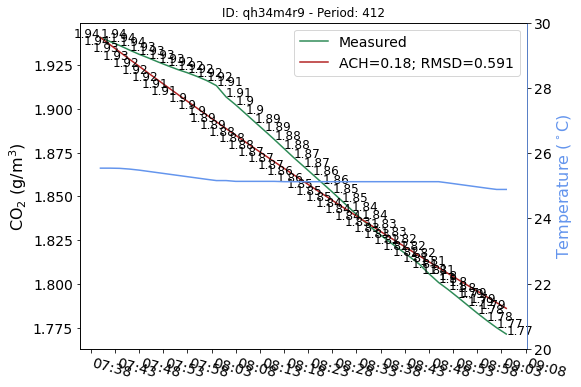

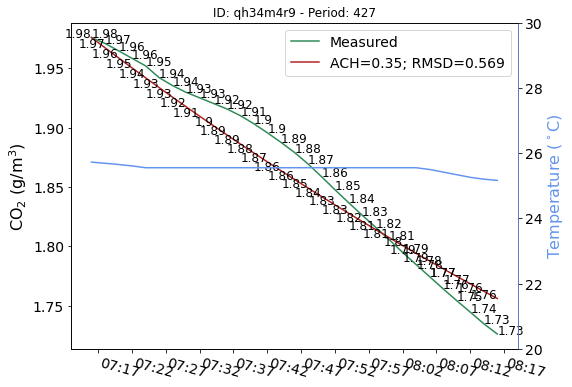

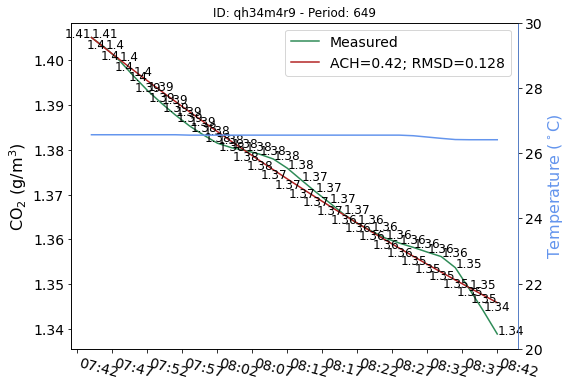

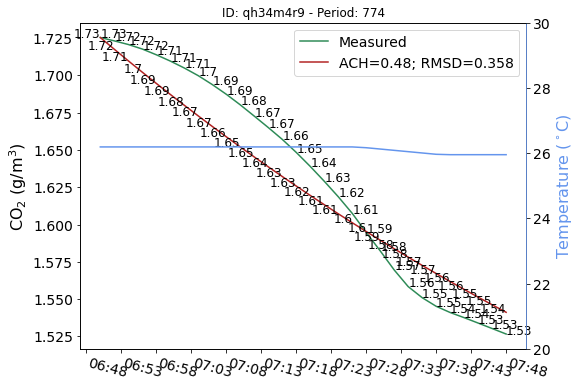

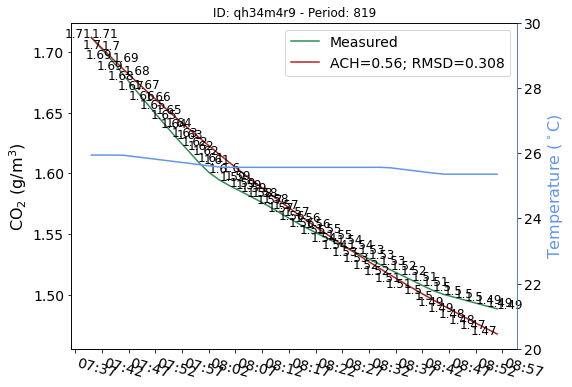

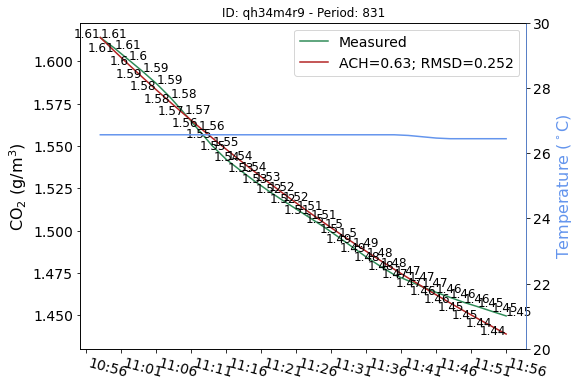

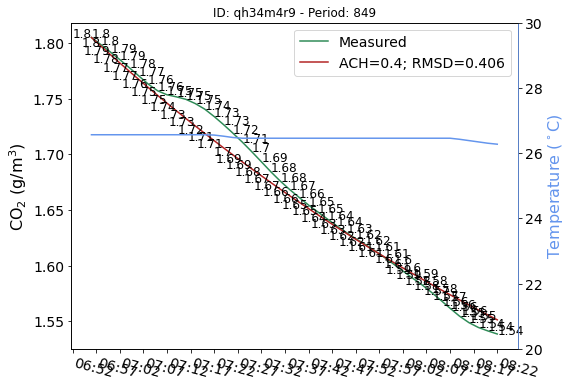

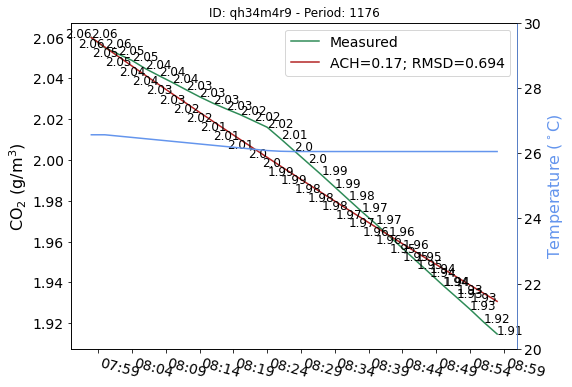

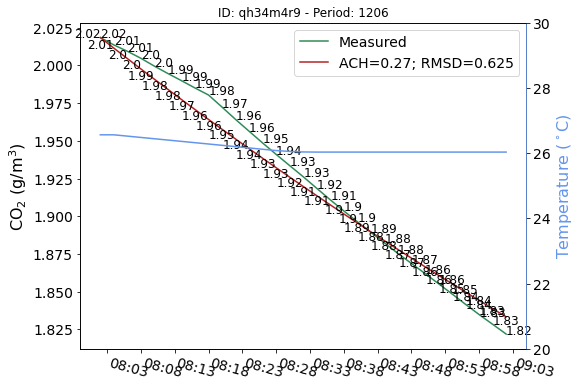

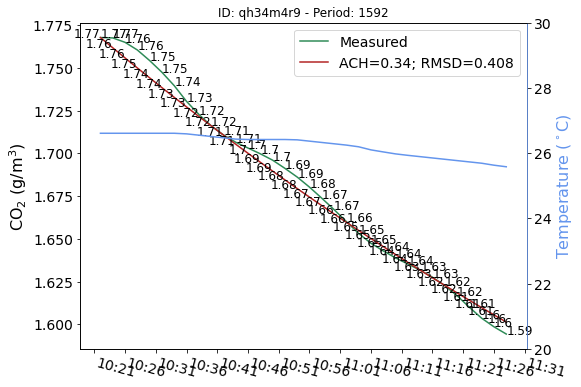

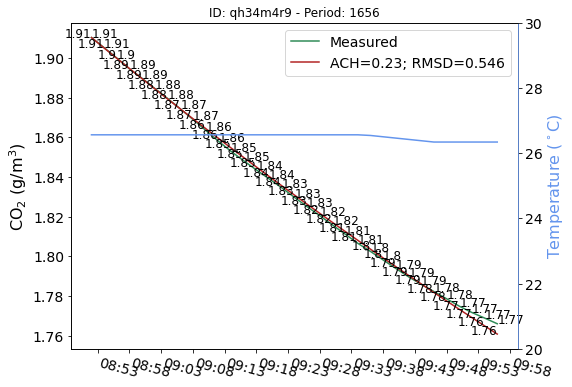

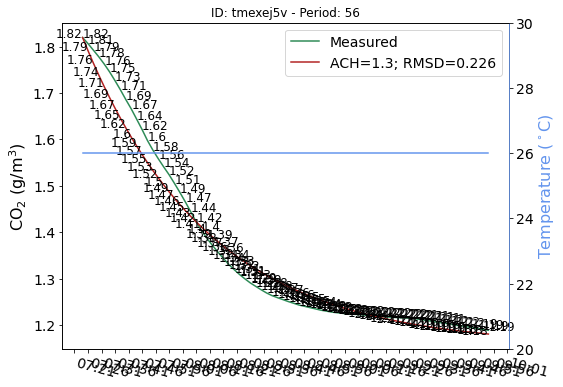

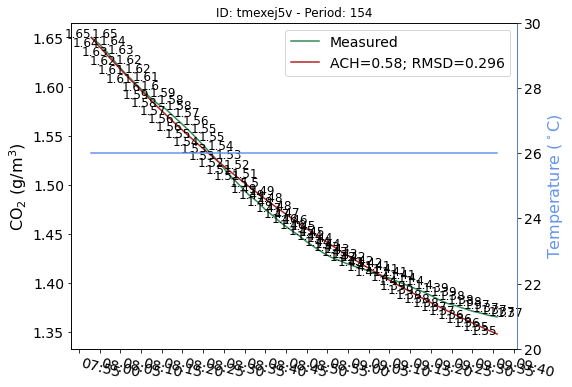

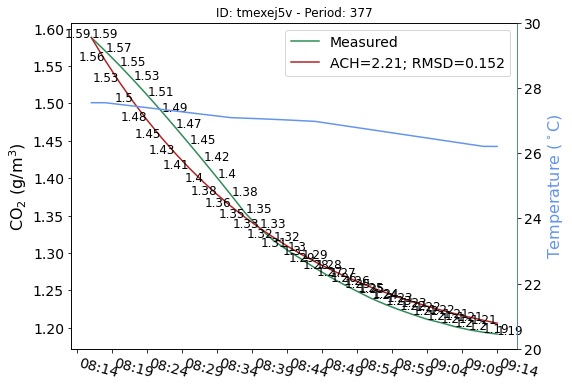

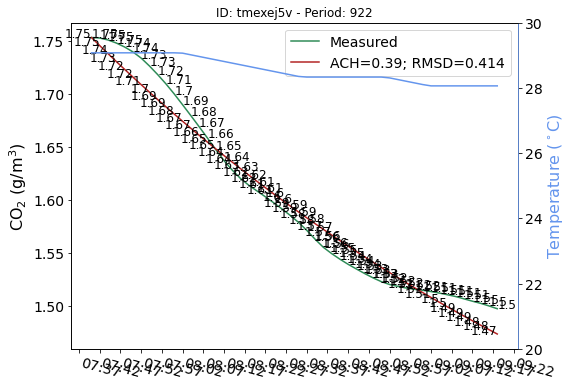

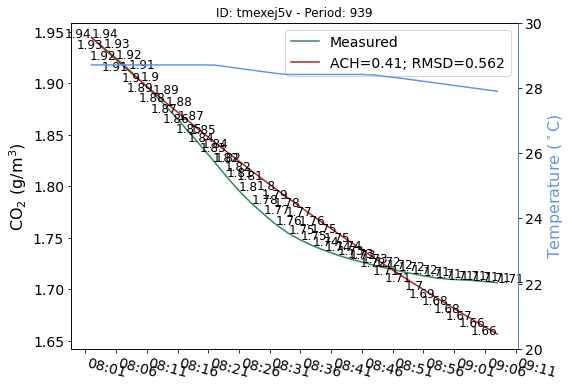

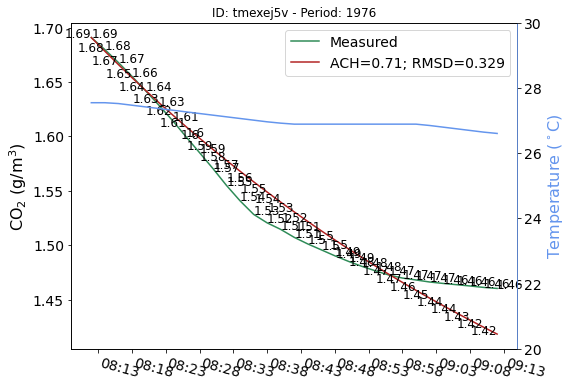

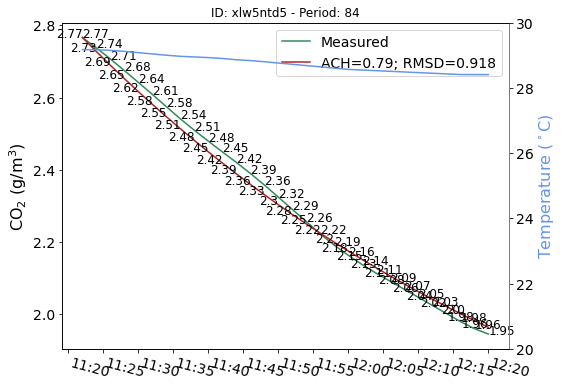

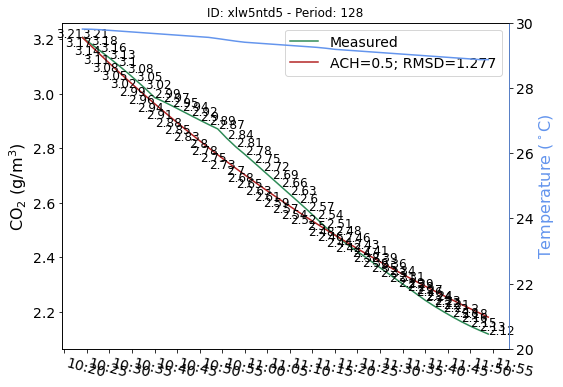

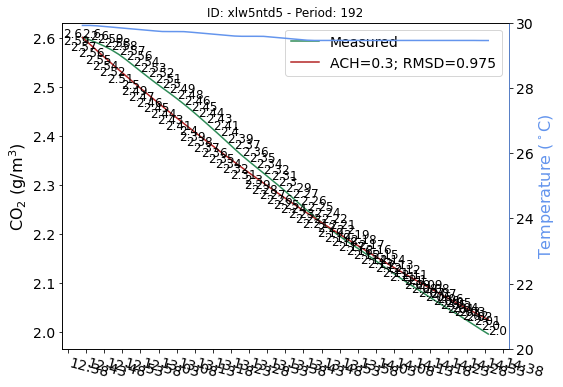

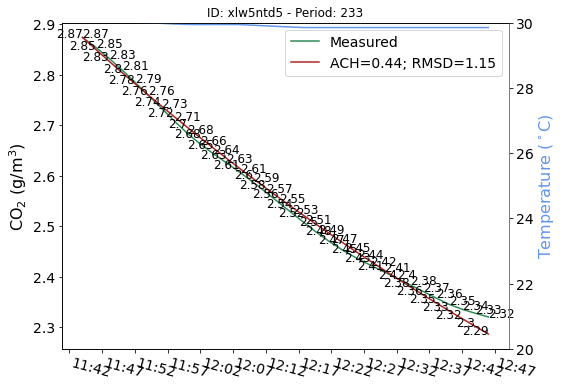

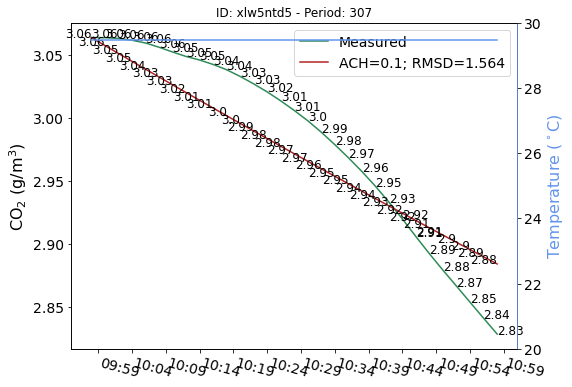

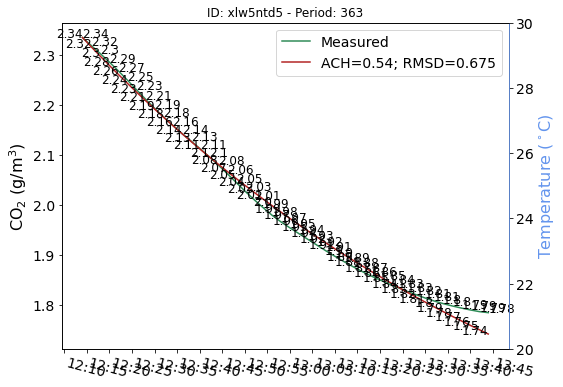

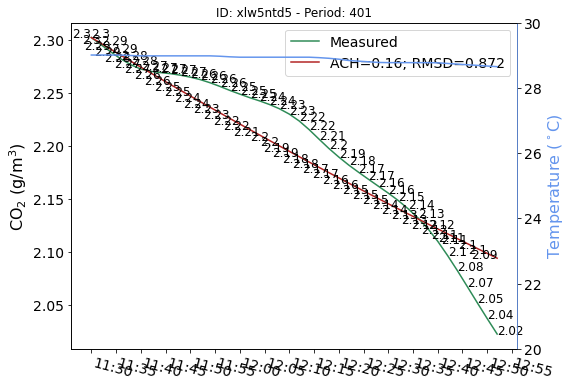

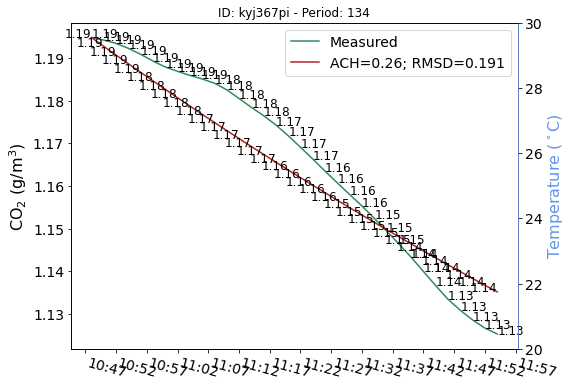

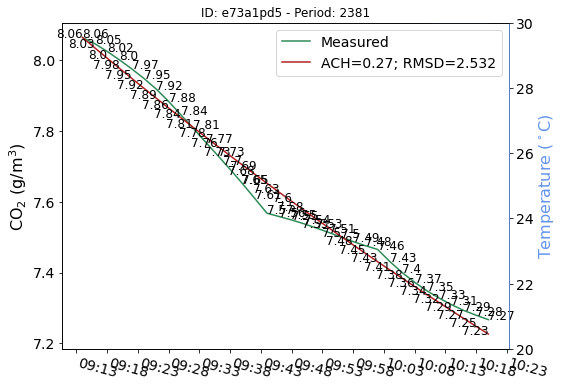

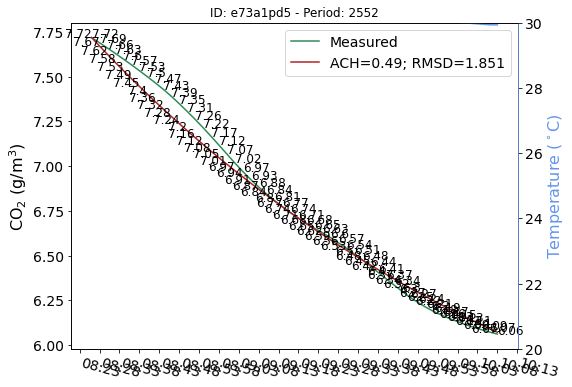

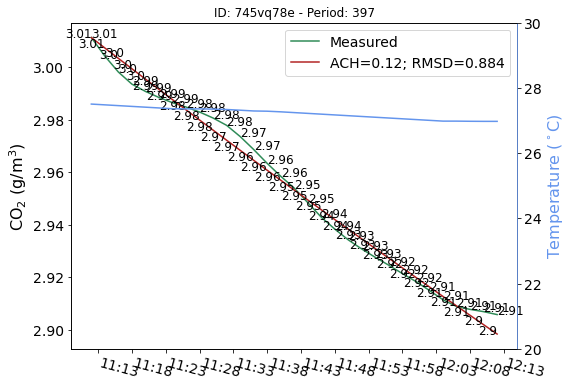

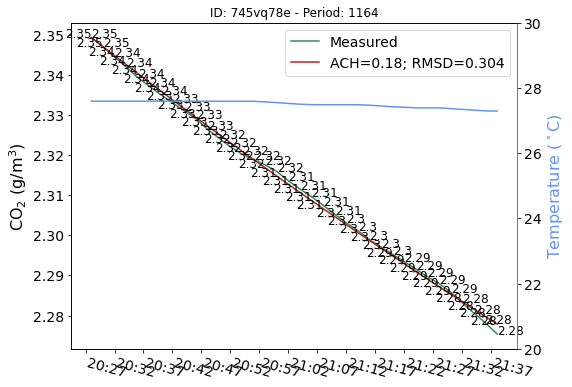

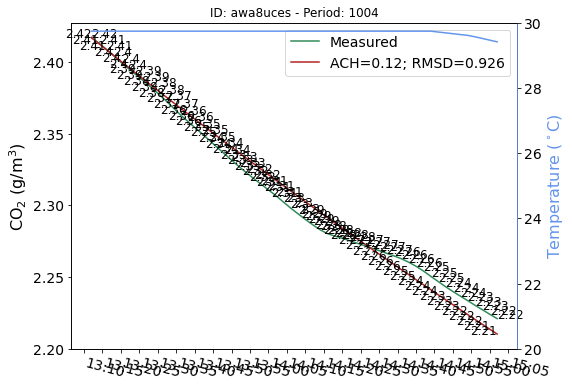

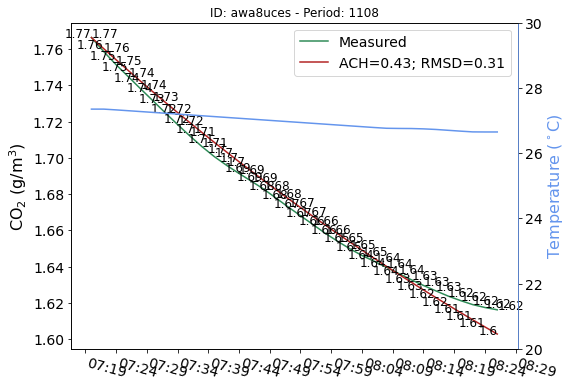

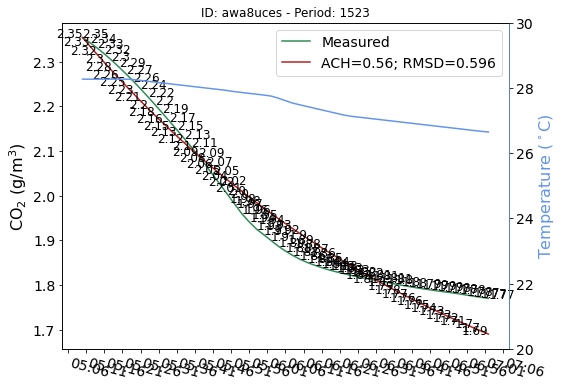

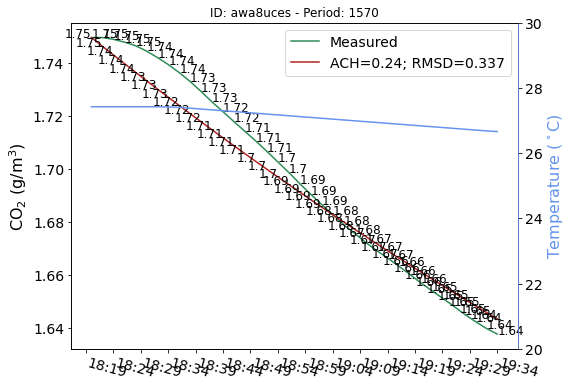

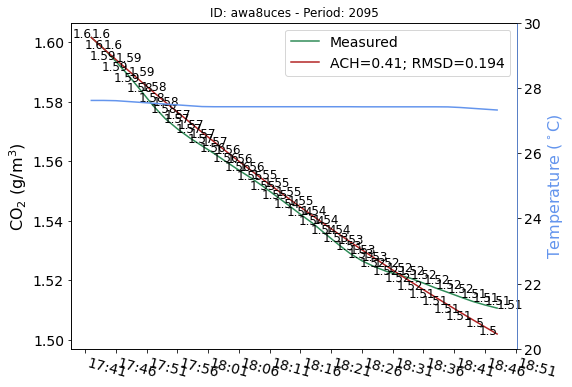

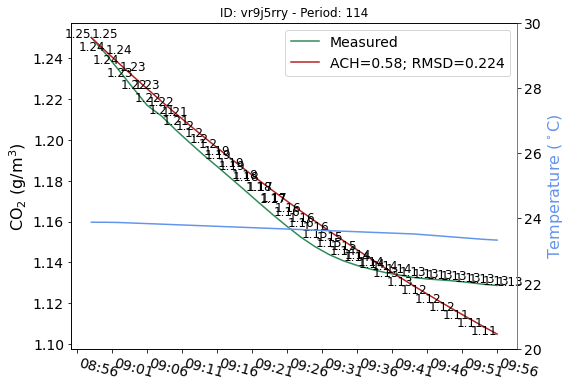

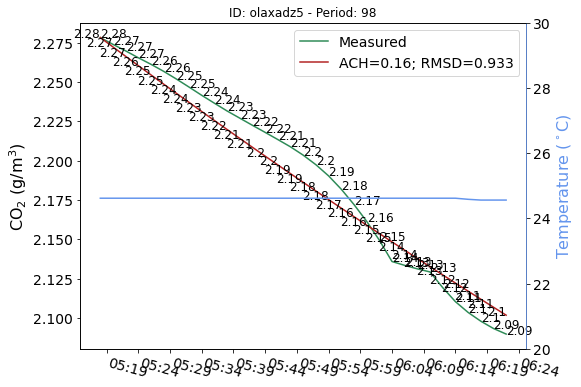

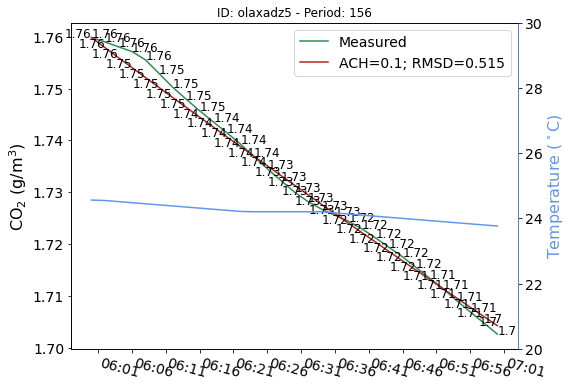

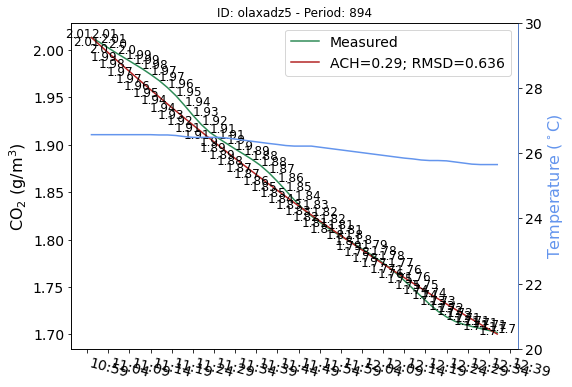

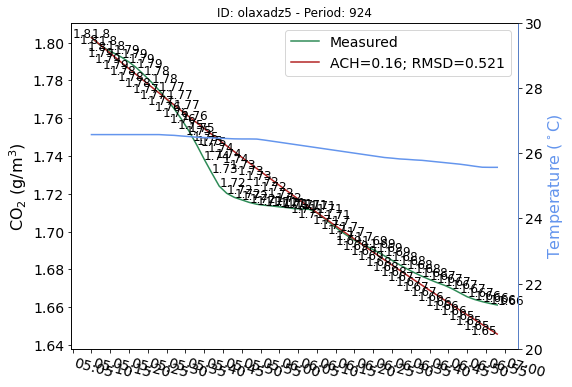

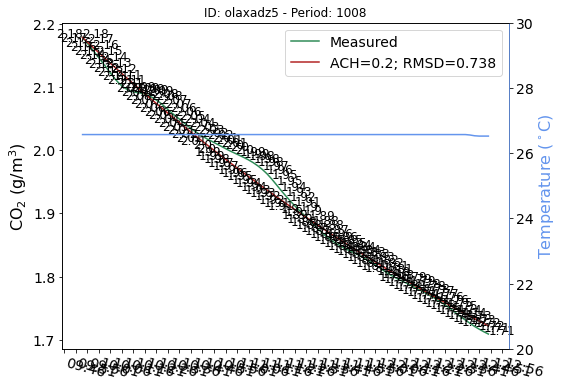

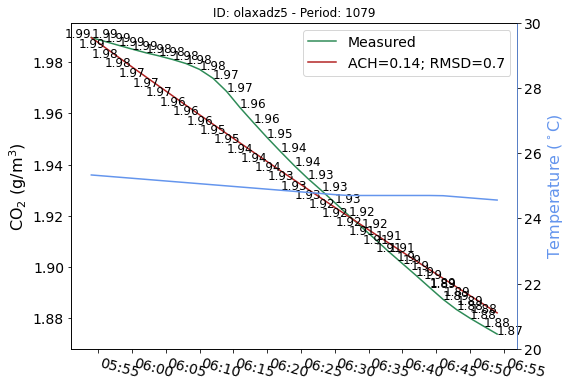

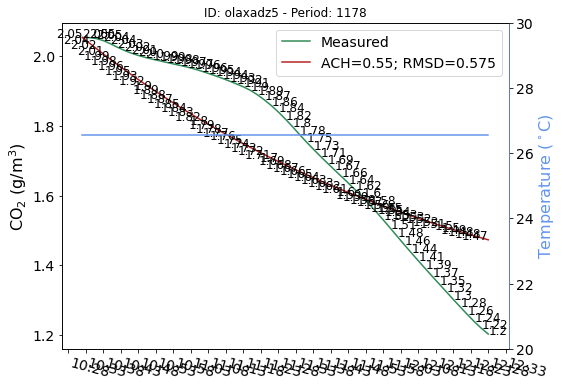

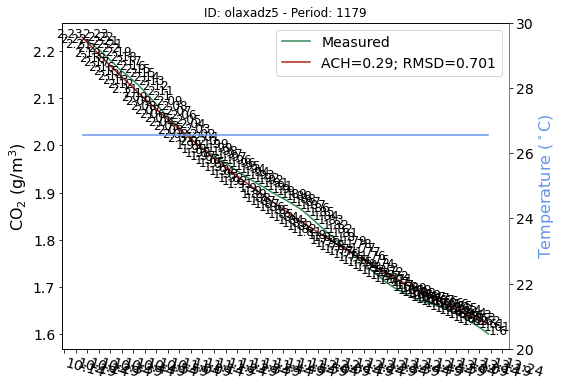

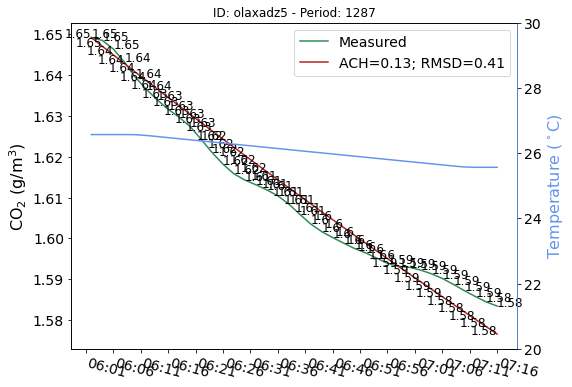

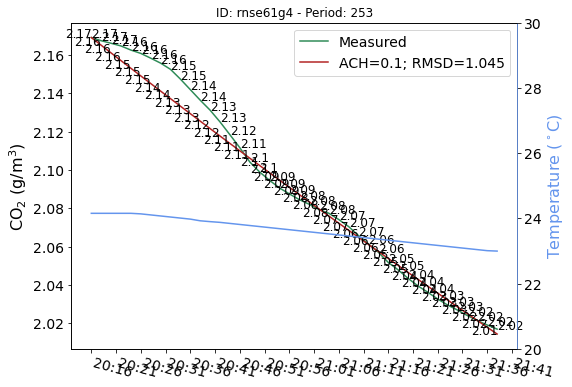

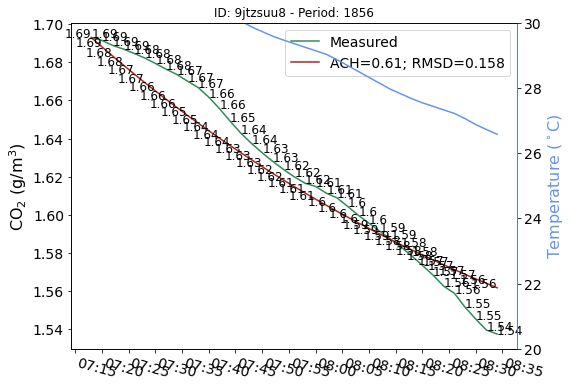

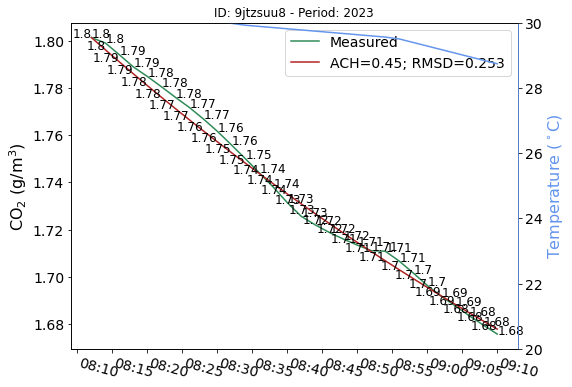

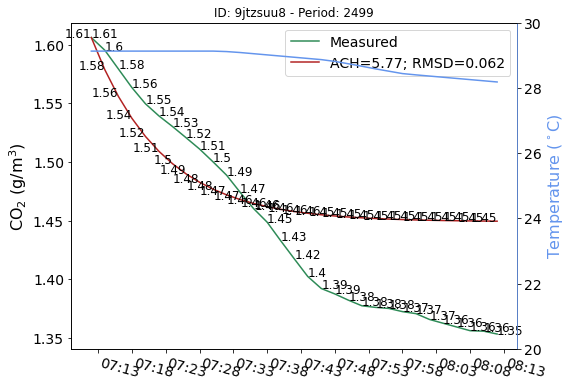

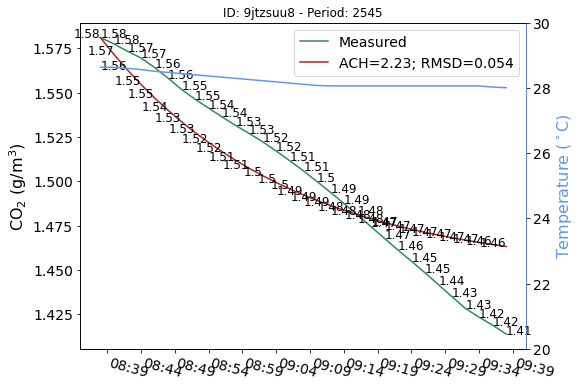

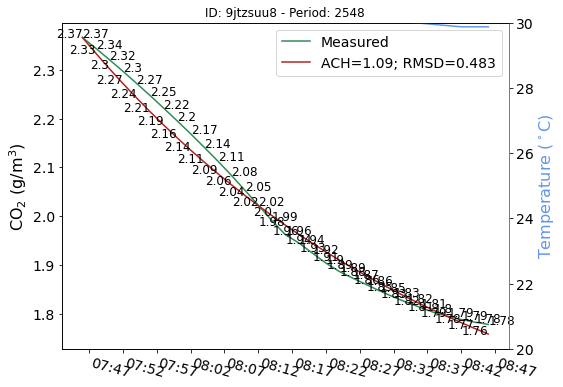

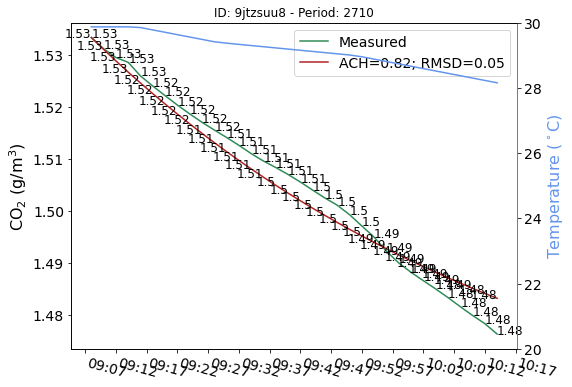

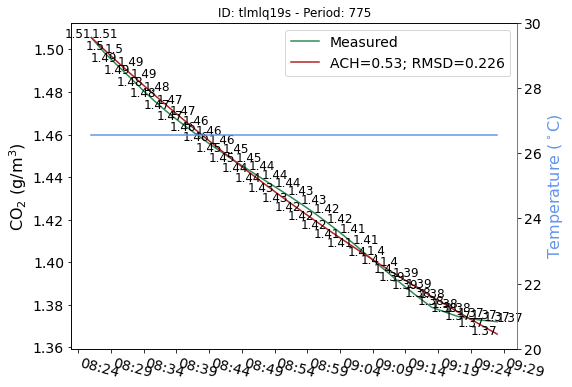

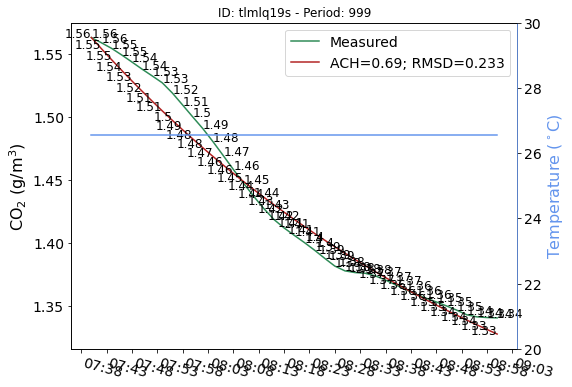

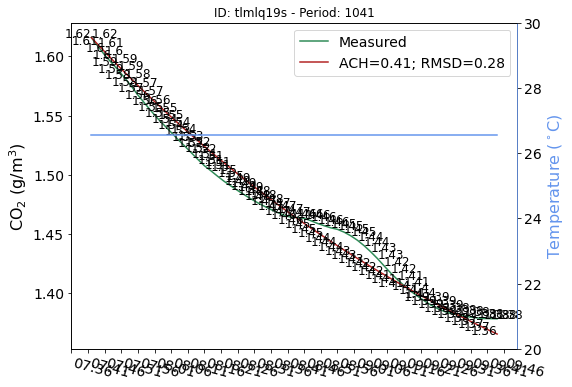

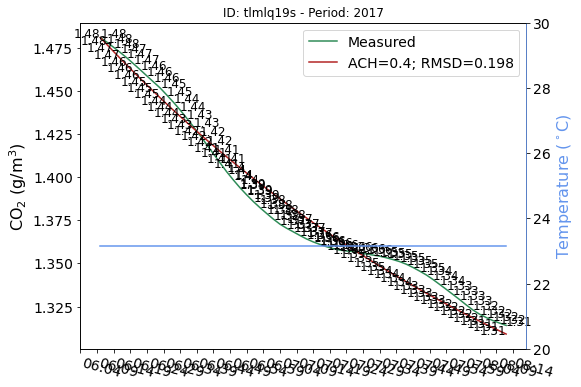

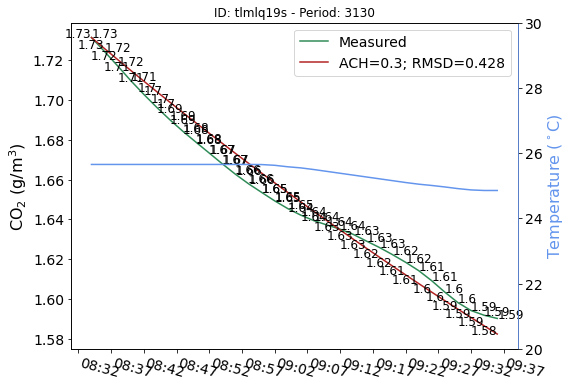

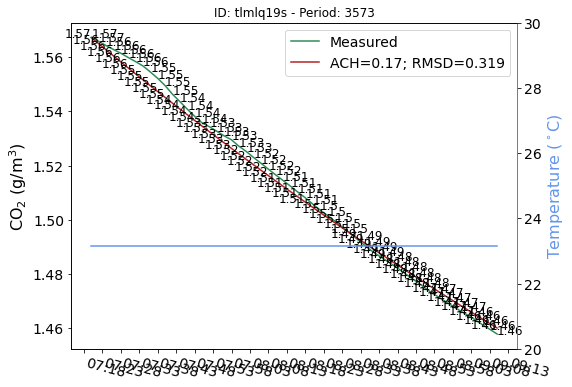

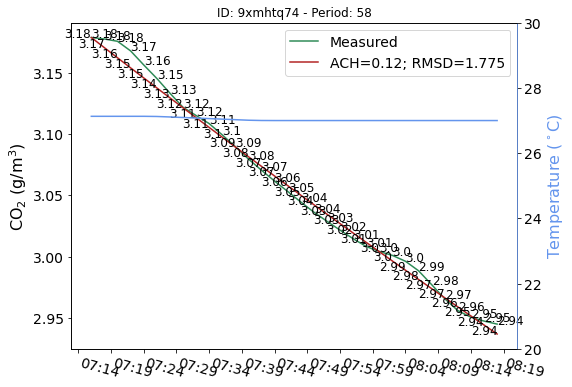

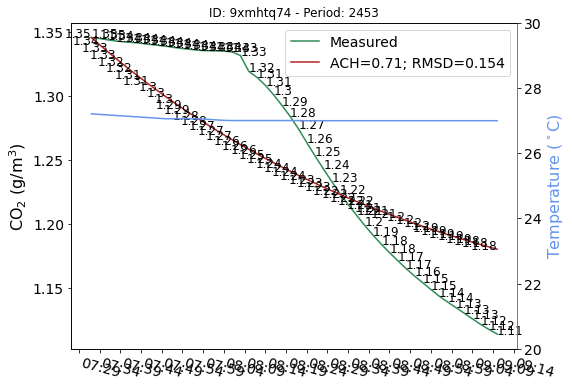

In [61]:
decay_2 = decay_calc.ventilation_decay_no_occupant(decay_calc.beacon_morning, decay_calc.info, plot=True)

Some exemplary participants and periods to consider. The optimal ACH is included.

* **Participant `lkkjddam`**:
    * Period 910 - 0.29
    * Period 3538 - 0.16
    * Period 3732 - 0.04 (lowest? calculated ACH)
    * Period 4238 - 0.29
* **Participant `qh34m4r9`**:
    * Period 819 - 0.23
    * Period 1656 - 0.13
* **Participant `tmexej5v`**:
    * Period 56 - 0.47
    * Period 154 - 0.26
    * Period 377 - 0.74 (highest calculated ACH)
    * Period 939 - 0.25
    * Period 1976 - 0.34

#### Participant lkkjddam

In [62]:
decay_morning_lkk = decay_calc.beacon_morning[decay_calc.beacon_morning["beiwe"] == "lkkjddam"]
decay_periods_lkk = decay_calc.get_co2_periods(decay_morning_lkk)

##### Period 910

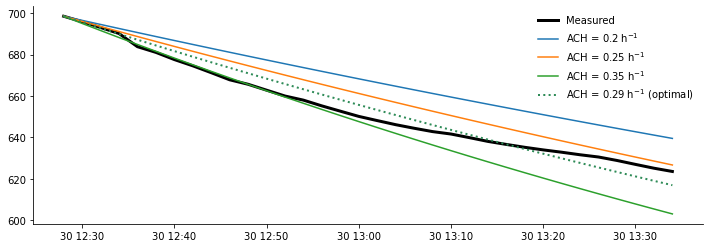

In [63]:
p910 = decay_periods_lkk[decay_periods_lkk["period"] == 910]
compare_decays(p910,ells=[0.2,0.25,0.35],c0=400,optimal=0.29)

##### Period 3538

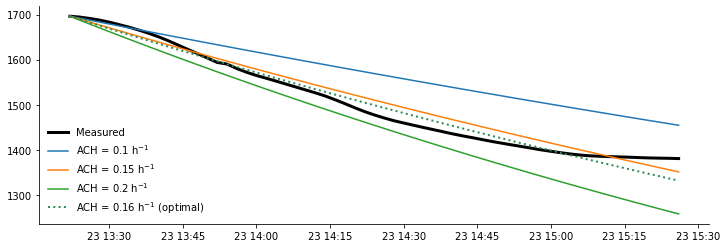

In [64]:
p3538 = decay_periods_lkk[decay_periods_lkk["period"] == 3538]
compare_decays(p3538,ells=[0.1,0.15,0.2],c0=400,optimal=0.16)

##### Period 3732

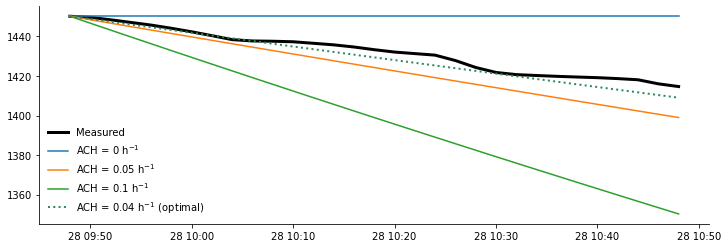

In [65]:
p3732 = decay_periods_lkk[decay_periods_lkk["period"] == 3732]
compare_decays(p3732,ells=[0,0.05,0.1],c0=400,optimal=0.04)

##### Period 4238

Using background of 400 ppm

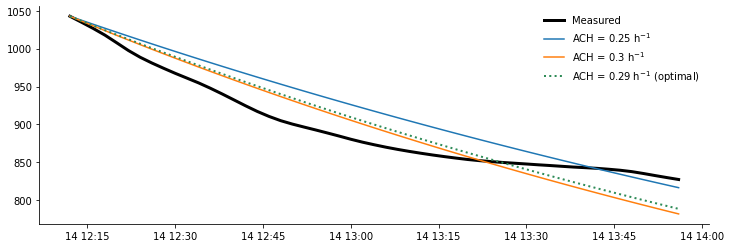

In [66]:
p4238 = decay_periods_lkk[decay_periods_lkk["period"] == 4238]
compare_decays(p4238,ells=[0.25,0.3],c0=400,optimal=0.29)

In [67]:
fifth_lkk = np.nanpercentile(decay_calc.beacon_all[decay_calc.beacon_all["beiwe"] == "lkkjddam"]["co2"],5)
print(fifth_lkk)

710.800953602541


Using a background of 710.8 ppm (5th percentile)

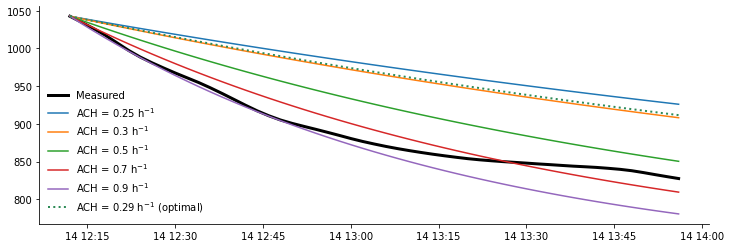

In [68]:
p4238 = decay_periods_lkk[decay_periods_lkk["period"] == 4238]
compare_decays(p4238,ells=[0.25,0.3,0.5,0.7,0.9],c0=fifth_lkk,optimal=0.29)

Using the fifth percentile increases the ventilation rate from 0.29 to approximately 0.7.

#### Participant tmexej5v
This participant contains a wide variety of good data to compare against.

In [69]:
decay_morning_tme = decay_calc.beacon_morning[decay_calc.beacon_morning["beiwe"] == "tmexej5v"]
decay_periods_tme = decay_calc.get_co2_periods(decay_morning_tme)

##### Period 56

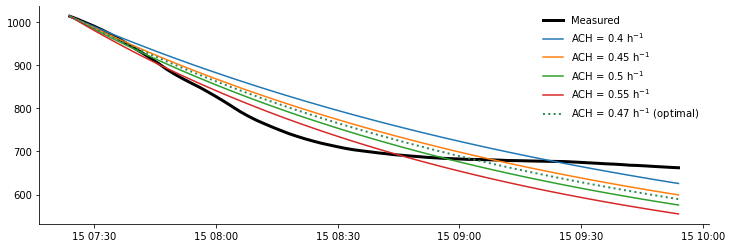

In [70]:
p56 = decay_periods_tme[decay_periods_tme["period"] == 56]
compare_decays(p56,ells=[0.40,0.45,0.5,0.55],c0=400,optimal=0.47)

##### Period 154

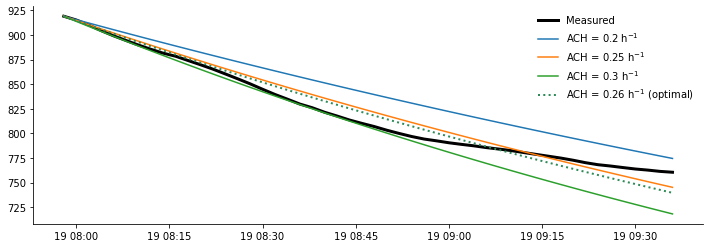

In [71]:
p154 = decay_periods_tme[decay_periods_tme["period"] == 154]
compare_decays(p154,ells=[0.2,0.25,0.3],c0=400,optimal=0.26)

##### Period 377

Using a background of 400 ppm

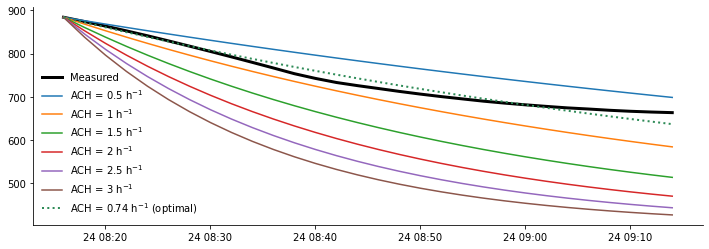

In [72]:
p377 = decay_periods_tme[decay_periods_tme["period"] == 377]
compare_decays(p377,ells=[0.5,1,1.5,2,2.5,3],c0=400,optimal=0.74)

Using the fifth percentile as the background (643.2 ppm)

643.1999884959337


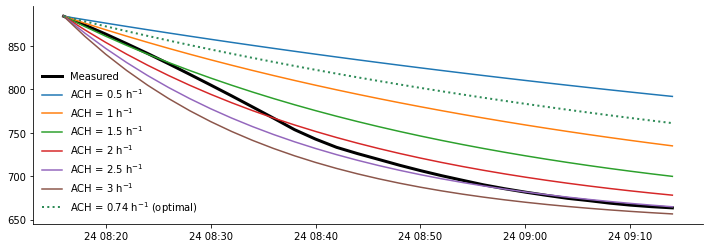

In [74]:
p377 = decay_periods_tme[decay_periods_tme["period"] == 377]
fifth_tme = np.nanpercentile(decay_calc.beacon_all[decay_calc.beacon_all["beiwe"] == "tmexej5v"]["co2"],5)
print(fifth_tme)
compare_decays(p377,ells=[0.5,1,1.5,2,2.5,3],c0=fifth_tme,optimal=0.74)

Using a background concentration of 643 ppm versus 400 ppm increased the optimal ventilation rate from 0.74 to approximately 2.4. 

<div class="alert-block alert alert-info">

This analysis reveals that the background co2 assumption of 400 ppm _heavily_ influences the resulting ach. By increasing this value, the ach for _all_ beacons approaches a more realistic value. This assumption is likely the most flawed so by accounting for it, we should be able to get more reasonable results. 
<div>

---

<a id="sensitivity_analysis"></a>

# Sensitivity Analysis
There are quite a few assumptions that are baked into the calculation and it would be interesting to see how ventilation estimates change when we vary the assumptions between _reasonable_ limits. There are three main parameters in both estimation methods that we should consider:
* $V$: volume of the bedroom
* $E$: person co2 emission rate
* $C_0$: background co2 concentration

The process will involve running the steady-state and decay (Eq 2) estimates again but varying one of the above parameters. We will determine a range of possible values for the above parameters and use a half-step approach where -1 steps would correspond to the lower limit, +1 steps would be the upper limit, and 1/2 steps would correspond to the values between the middle of the range and the lower/upper limits. 

Determining the limits is not as straight-forward as expected and depends on the parameter.

In [87]:
sa = ventilation.calculate(data_dir="../data")

### Volume
The limits for this parameter _are_ easy to determine. We simply need to determine reasonable values for the volume of an apartment and home bedroom.

#### Apartment
The [minimum floor area](https://buildingcodetrainer.com/minimum-bedroom-size/) for a bedroom with a single occupant is 70 ft$^2$. We can use this number along with the fact that [ceiling heights](https://www.hunker.com/12591709/what-is-the-minimum-ceiling-height-according-to-the-international-building-code) must be a minimum of 7 ft to get **490 ft$^3$ as the minimum $V$**. 

The maximum will be whatever volume ensures that the default value of 1080 ft$^3$ is the center of the limit, meaning **1670 ft$^3$ as the maximum $V$**. 

#### House
The minimum bedroom size for a home is still the same by code, but we will increase one dimension by one foot to get **650 ft$^3$ as the maximum $V$**.

In the same manner, the maximum volume is chosen to ensure that the default value is the midpoint. Therefore **1726 ft$^3$ is the maximum $V$**. 

<div class="alert-block alert alert-info">

**Apartment**: 490 - 1670
    
**Home**: 650 - 1726
<div>

### Emission Rate
These limits are a bit trickier to estimate. The equation we are using for the emission rate, shown [above](#emission_rate_discussion), depends on a few variables. In the points below, we highlight the process we will use to determine limits on emission rate:
* $T$: we can use the minimum and maximum temperature measured during the evenings for the range of possible temperatures. _$T$ is directly related to $E$_.
* $P$: while there are likely variations in pressure depending on the location, I think it is safe to assume a constant $P$ - **we will hold $P$ constant**. 
* $BMR$: BMR is dependent on the mass and sex of the individual. I think we are safe to use the minimum and maximum mass per sex to establish a limit on the mass for each sex and therefore BMR. _$BMR$ is directly related to $E$_.
* $M$: the activity level measured as METs should be held constant since we are safe to assume the participant is asleep - **we will hold $M$ constant**. 

#### Temperature

In [76]:
min_t = np.nanmin(sa.beacon_nightly["temperature_c"])
max_t = np.nanmax(sa.beacon_nightly["temperature_c"])
print(f"Min:\t{min_t}\nMax:\t{max_t}")

Min:	15.38867915217
Max:	33.1368318835


#### BMR

In [77]:
sa.info[["sex","mass","bmr"]].groupby(["sex"]).min()

mass       bmr
sex                        
Female  47.173568  4.960761
Male    58.962424  6.610633

In [78]:
sa.info[["sex","mass","bmr"]].groupby(["sex"]).max()

mass       bmr
sex                        
Female  80.720737  7.040686
Male    83.914520  8.182615

#### Rate


In [155]:
min_e_f = sa.get_emission_rate(BMR=4.96,T=15.4+273.15)
max_e_f = sa.get_emission_rate(BMR=7.04,T=33.1+273.15)
min_e_m = sa.get_emission_rate(BMR=6.61,T=15.4+273.15)
max_e_m = sa.get_emission_rate(BMR=8.18,T=33.1+273.15)
print(f"Female:\n\tMin\t{min_e_f}\n\tMax\t{max_e_f}\nMale:\n\tMin\t{min_e_m}\n\tMax\t{max_e_m}")

Female:
	Min	0.0023744089795121946
	Max	0.0035768565853658532
Male:
	Min	0.0031642829343902427
	Max	0.004156063475609755


<div class="alert-block alert alert-info">

**Female**: 0.0023744089795121946 - 0.0035768565853658532
    
**Male**: 0.0031642829343902427 - 0.004156063475609755
<div>

### Background CO$_2$ Concentration
We have already seen how important this variable is in the above analysis with the decay esimate. While, on the surface, this variable seems easy to manipulate, there are two configurations I want to investigate:
1. **Vary CO$_2$ within constant limit**: Just like with $V$, we will determine a reasonable range of background CO$_2$ and apply it across _all_ participants. 
2. **Vary CO$_2$ within participant-based limit**: We will use percentiles of CO$_2$ measurements specific to each participant to determine a range of background concentrations.

<div class="alert-block alert alert-info">

**Constant**: 400 - 500
    
**Participant-Based**: 0th percentile (minimum) - 10th percentile
<div>

In [ ]:
sa = ventilation.calculate(data_dir="../data")

## Steady-State Estimates

In [321]:
res_sa_ss = sa.run_sensitivity_analysis(ss=True,params=["e","v","c0"],steps=[0,0.25,0.75,1],constant_c0=False,verbose=False)

In [394]:
def compare_sa_to_base(sa_results,base_estimates,params=["v","e","c0"],steps=[0,0.25,0.75,1],plot=False,save_plot=False):
    """
    Aggregates the sensitivity analysis results and compares them to the baseline estimates
    
    Parameters
    ----------
    sa_results : DataFrame
        ventilation estimates for each night from each participant with the parameters adjusted
    base_estimates : DataFrame
        baseline ventilation estimates for each night from each participant
    params : list of str, default ["v","e","c0"]
        parameters to include in the analysis
    steps : list of float, default [0,0.25,0.75,1]
        steps within the limits to consider
    plot : boolean, default False
        whether to plot the summary
    save_plot : boolean, default False
        whether to save the summary plot
    
    Returns
    -------
    <results> : DataFrame
        aggregate percent increase results for each step from each parameter
    """
    # setting up results dict
    aggregate_res = {step: [] for step in steps}
    aggregate_res["parameter"] = []
    # getting aggregate results
    for param in params:
        sa_param = sa_results[sa_results["parameter"] == param]
        aggregate_res["parameter"].append(param)
        for step in steps:
            perc_inc = []
            for pt in sa_results["beiwe"].unique():
                sa_pt = sa_param[sa_param["beiwe"] == pt]
                estimate_pt = base_estimates[base_estimates["beiwe"] == pt]
                perc_inc.append((np.nanmean(sa_pt[sa_pt["step"] == step]["ach"]) - np.nanmean(estimate_pt["ach"])) / np.nanmean(estimate_pt["ach"]))
                
            aggregate_res[step].append(round(np.nanmean(perc_inc),4)*100)

    results = pd.DataFrame(aggregate_res).set_index("parameter")
    if plot:
        _, ax = plt.subplots(figsize=(10,6))
        ax.barh(results.index,results.iloc[:,0],left=results.iloc[:,1],color="steelblue",edgecolor="k",label="-1 Step")
        ax.barh(results.index,results.iloc[:,1],color="deepskyblue",edgecolor="k",label="$\\frac{-1}{2}$ Step")
        ax.barh(results.index,results.iloc[:,2],color="goldenrod",edgecolor="k",label="$\\frac{+1}{2}$ Step")
        ax.barh(results.index,results.iloc[:,3],color="darkorange",left=results.iloc[:,2],edgecolor="k",label="+1 Step")
        # x-axis
        ax.set_xlabel("Percent Change",fontsize=14)
        # y-axis
        ax.set_yticklabels([p.title() for p in params])
        ax.set_ylabel("Parameter",fontsize=14)
        
        # remainder
        ax.tick_params(labelsize=12)
        ax.legend(frameon=False,fontsize=12)
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        plt.show(),
        plt.close()
    
    return results

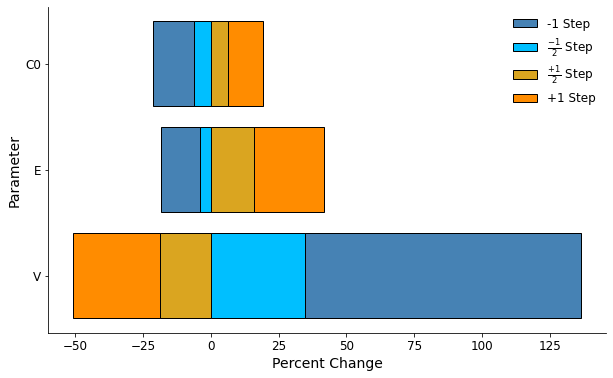

In [396]:
sa_ss_summary = compare_sa_to_base(res_sa_ss,estimates_ss,steps=[0,0.25,0.75,1],plot=True)

<div class="alert-block alert alert-info">

The volume seems to have the greatest effect on the ventilation estimates although we are taking ranges that are outside the dataset. Higher emission rates also tended to have a more pronounced effect on the ventilation rate. 
<div>

## Decay Estimates

In [413]:
res_sa_decay = sa.run_sensitivity_analysis(ss=False,params=["c0"],steps=[0,0.25,0.75,1],constant_c0=False,verbose=True)

Participant nvtfpaor
	Home
	Female
	Param: c0
		Step: 0 - 0.058
		Step: 0.25 - 0.058
		Step: 0.75 - 0.058
		Step: 1 - 0.058
Participant lkkjddam
	Home
	Male
	Param: c0
		Step: 0 - 0.163
		Step: 0.25 - 0.179
		Step: 0.75 - 0.196
		Step: 1 - 0.203
Participant itmylz3g
	Home
	Female
	Param: c0
		Step: 0 - nan
		Step: 0.25 - nan
		Step: 0.75 - nan
		Step: 1 - nan
Participant zdpffrox
	Apt
	Male
	Param: c0
		Step: 0 - 0.082
		Step: 0.25 - 0.087
		Step: 0.75 - 0.089
		Step: 1 - 0.089
Participant qh34m4r9
	Home
	Male
	Param: c0
		Step: 0 - nan
		Step: 0.25 - nan
		Step: 0.75 - nan
		Step: 1 - nan
Participant tmexej5v
	Home
	Female
	Param: c0
		Step: 0 - 0.26
		Step: 0.25 - 0.296
		Step: 0.75 - 0.33
		Step: 1 - 0.337
Participant xlw5ntd5
	Home
	Female
	Param: c0
		Step: 0 - 0.101
		Step: 0.25 - 0.109
		Step: 0.75 - 0.112
		Step: 1 - 0.113
Participant idbkjh8u
	Apt
	Female
	Param: c0
		Step: 0 - nan
		Step: 0.25 - nan
		Step: 0.75 - nan
		Step: 1 - nan
Participant kyj367pi
	Apt
	Female
	Param: 

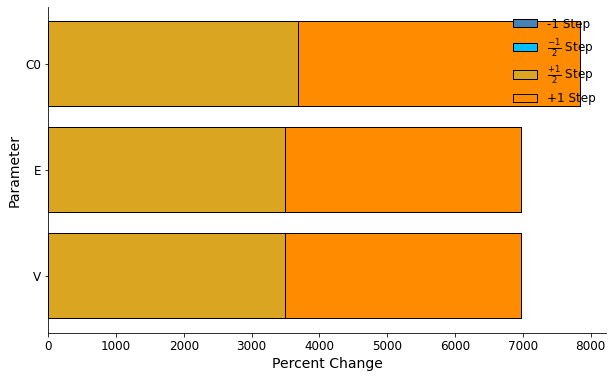

In [404]:
sa_decay_summary = compare_sa_to_base(res_sa_decay,decay_1,steps=[0,0.25,0.75,1],plot=True)

In [410]:
sa_decay_summary

0     0.25     0.75        1
parameter                                    
v          3488.57  3488.57  3488.57  3488.57
e          3488.57  3488.57  3488.57  3488.57
c0         3126.83  3327.69  3686.23  4149.09

---